In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import gc # Free up memory

import scipy.stats
import scipy.special

import copy
import pandas as pd
# Imports
import pandas as pd
import numpy as np
#from keras.models import Sequential
#from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
#from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# fetch data

In [27]:


#from imblearn.over_sampling import SMOTE

# Load the data from CSV files into DataFrames
zone_data_1A = pd.read_csv('../[3.1] - OUTLIER_REMOVAL/zone_data_1A_MONTHLY.csv')
zone_data_7 = pd.read_csv('../[3.1] - OUTLIER_REMOVAL/zone_data_7_MONTHLY.csv')
zone_data_6 = pd.read_csv('../[3.1] - OUTLIER_REMOVAL/zone_data_6_MONTHLY.csv')


# Copy the data to avoid SettingWithCopyWarning
zone_data_1A_top_sorted = zone_data_1A.copy()
#zone_data_1A_bottom_sorted = zone_data_1A_bottom.copy()

# Copy the data for zone 6 and zone 7 to avoid SettingWithCopyWarning
zone_data_6_top_sorted = zone_data_6.copy()
#zone_data_6_bottom_sorted = zone_data_6.copy()

zone_data_7_top_sorted = zone_data_7.copy()
#zone_data_7_bottom_sorted = zone_data_7.copy()

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_1A_top_sorted.sort_values(by='date', ascending=True, inplace=True)
#zone_data_1A_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_6_top_sorted.sort_values(by='date', ascending=True, inplace=True)
#zone_data_6_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zone_data_7_top_sorted.sort_values(by='date', ascending=True, inplace=True)
#zone_data_7_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)






# Functions to run rolling optimisation and save as csv

In [28]:
def default_kwargs():
    return {'enforce_stationarity': False, 'order':(10, 2, 10)}

def build_arma_model(data, kwargs=None, model_func=ARIMA):
    # Function to create and fit model. By default it fits an ARIMA model.
    # Can take any other function of the form model_func(data, **kwargs) where data is the training predictive set
    # Exogenous variables and other arguments can be passed with kwargs (dictionary with keyword arguments)
    if kwargs is None:
        kwargs = default_kwargs()
    # ARMA model is a special case of ARIMA with no differencing (d=0)
    #if model_func == sm.tsa.statespace.SARIMAX:
    #    kwargs.update({'seasonal_order': (1, 1, 1, 12)})
    # Dont use seasonality
    model = model_func(data, **kwargs)
    fitted_model = model.fit()
    return fitted_model

def forecast_and_simulate(model, steps=1000, prediction_kwargs={}):
    # Get the forecast result
    forecast_result = model.get_forecast(steps=steps, **prediction_kwargs)
    forecast_mean = forecast_result.predicted_mean

    # Convert MultiIndex DataFrame to standard column format
    conf_intervals = forecast_result.conf_int()
    conf_intervals.columns = ['lower', 'upper']

    return forecast_mean, conf_intervals

def run_arma(train_data, test_data,  predictive_col='mean_price', kwargs=None, model_func=ARIMA, prediction_kwargs={}):
    
    # Run ARIMA model and get output
    arma_model = build_arma_model(train_data.reset_index()[predictive_col], kwargs=kwargs, model_func=model_func)
    forecast_series, conf_df = forecast_and_simulate(arma_model, steps=len(test_data), prediction_kwargs=prediction_kwargs)
    
    # Store output in dataframe
    df = pd.concat([pd.DataFrame(np.zeros((train_data.shape[0], 2)), columns=conf_df.columns), conf_df])
    df = df.assign(value=pd.concat([train_data.reset_index()[predictive_col], forecast_series]), start=len(train_data))
    
    return df

def stochastic_forecast(model, steps=1000):

    forecast_result = model.get_forecast(steps=steps)

In [29]:
def make_dataset(zone_data, col, output_name, kwargs={}, model_func=ARIMA,  clean_up=True, start_base=10, stop_val=None, exog_cols=None, prediction_kwargs={}):
    dfs = []
    if stop_val is None:
        stop_val = len(zone_data)

    
    kwargs.update(default_kwargs())
    if kwargs is None:
        kwargs = default_kwargs()
    

    # Run arma for different starting times to use in optimisation (could call every time an evaluation is needed but this saves computation)
    for start in np.arange(int(start_base), np.minimum(stop_val, len(zone_data))):
        train_data = zone_data.iloc[:start, :]
        test_data = zone_data.iloc[start:, :]

        # Add exogenous data to the keyword arguments
        if exog_cols is not None:
            if kwargs is None:
                kwargs = default_kwargs()
            kwargs.update({'exog':train_data.reset_index()[exog_cols]})
            prediction_kwargs.update({'exog':test_data.reset_index()[exog_cols]})
            
        dfs.append(run_arma(train_data, test_data, predictive_col=col, kwargs=kwargs, model_func=model_func, prediction_kwargs=prediction_kwargs))
        
    pd.concat(dfs).to_csv(f'{output_name}.csv')

    if clean_up:
        # Delete the probably sizeable dataframe generated to free up memory
        del dfs
        gc.collect()

def get_predictions(df, t, start):
    # Previously returned as np array, changed to series for compatability with filtered datasets
    try:
        return df.loc[df.start==start, :].loc[t, 'value']#.clip(lower=0, upper=10**6)
    except:
        return df.loc[(df.start==start)&np.in1d(df.index, t), 'value']#.clip(lower=0, upper=10**6)
        
def ranking(df, ax=None, kwargs={}):

    t = df.index.unique()
    df["Rank"] = np.nan
    for start in df.start.unique():
        pred = get_predictions(df, t, start)

        ranks = scipy.stats.rankdata(pred)

        #ranks = scipy.stats.rankdata(pred)
        
        df.loc[df.start==start, 'Rank'] = ranks

    if ax is not None:
        rank_df = copy.deepcopy(df)
        rank_df = rank_df.assign(value=rank_df.Rank)
        plot_residuals(rank_df, ax, **kwargs)
# Set global font size
plt.rcParams.update({'font.size': 14})

def plot_dataset(df, ax):
    # Set up for consistent colour mapping
    norm = mpl.colors.Normalize(vmin=min(df.start.unique()), vmax=max(df.start.unique()))
    map = cm.ScalarMappable(norm=norm, cmap='viridis')

    t = df.index.unique()
    
    # Plotting the data for different starts
    for start in df.start.unique():
        pred = get_predictions(df, t, start)
       # ax.plot(t, get_predictions(df, t, start), c=map.get_cmap()(norm(start)))
        ax.plot(pred.index, pred, c=map.get_cmap()(norm(start)))
    # Formatting plot
    plt.colorbar(map, ax=ax, label="Testing Period Start")
    ax.set_ylim(0, max(get_predictions(df, t, max(df.start))))
    
    ax.set_ylim(0, max(get_predictions(df, t, max(df.start))))

def MAEs(df):
    df["Observed"] = df.index
    df["Observed"] = df["Observed"].map(df.loc[df.start==df.start.max(), 'value'])

    ranking(df)
    df["Observed Rank"] = df.index.map(df.loc[df.start==df.start.max(), 'Rank'])
    
    # was absolute before, value clipped
    df = df.assign(error=(df.value-df.Observed), rank_error = (df.Rank-df["Observed Rank"]))

    return df

def read_rmse(datasetname):
    df = pd.read_csv(datasetname, index_col=0)
    df = MAEs(df)

    return (df.error[df.start>df.index].mean(), df.error[df.start<=df.index].mean()), (df.rank_error[df.start>df.index].mean(), df.rank_error[df.start<=df.index].mean())

def plot_residuals(df, ax, group_size=None, comparison_ax=None, label=None, rank=False):
    if rank:
        ranking(df, ax, kwargs=dict(group_size=group_size, comparison_ax=comparison_ax, label=label))
        return
    # Set up for consistent colour mapping
    norm = mpl.colors.Normalize(vmin=min(df.start.unique()), vmax=max(df.start.unique()))
    map = cm.ScalarMappable(norm=norm, cmap='viridis')

    t = df.start.unique()

    if group_size is None: # used to be 15
        group_size = int(len(t)/12)

    df["Observed"] = df.index
    df["Observed"] = df["Observed"].map(df.loc[df.start==df.start.max(), 'value'])

    df = df.assign(offset=df.index-df.start, offset_group=(np.floor((df.index-df.start)/group_size)*group_size).astype(int),error=abs(df.value.clip(lower=0, upper=10**6)-df.Observed))

    df.loc[df.index<df.start, 'error'] = np.nan
    df.loc[df.index<df.start, 'offset_group'] = np.nan

    

    for start in df.start.unique():
        t_in  = t[t>=start]
       # ax.plot(t_in-start, get_predictions(df, t_in, start) - get_predictions(df, t_in, df.start.max()), c=map.get_cmap()(norm(start)), alpha=0.1)

    pos = df.groupby('offset_group').offset.min() + group_size/2
    df.boxplot(column='error', by='offset_group', ax=ax, showfliers=False, grid=False, positions=pos, widths=0.8*group_size)

    mse = np.sqrt((df.error**2).mean())
    ax.axhline(mse, ls='--', c='k')

    ax.title.set_text(f"{label}, MAE = {mse:,.1f}")

    ax.set_xticks(ticks = pos, 
                  labels=[f"{min_:.0f}-{max_:.0f}" for min_, max_ in zip(df.groupby('offset_group').offset.min(), df.groupby('offset_group').offset.max())],
                  rotation=20,
                  ha='right')

    ax.set_xlabel("Steps from start")
    ax.set_ylabel("Error")

    ax.set_yscale('log')

    a = [ax]
    if comparison_ax:
        comparison_ax.plot(df.groupby('offset').offset.median(), df.groupby('offset').error.median(), label=label)
        comparison_ax.fill_between(df.groupby('offset').offset.median(), 
                                   df.groupby('offset').error.quantile(0.25), df.groupby('offset').error.quantile(0.75),
                                   alpha = 0.1)
        a.append(comparison_ax)

    for ax_ in a:
        ax_.set_xlabel("Steps from start")
        ax_.set_ylabel("Error")

        ax_.set_yscale('log')
    


In [30]:
# Create a monthly aggregate
zone_data = zone_data_1A_top_sorted
zone_data.Create_date = pd.to_datetime(zone_data['date'])
#grouped = zone_data.groupby(pd.Grouper(key="Create_date", freq='M'))
# Take the median of the monthly price
#zone_data = grouped[["Price Per ML ($)", "Volume Traded (ML)"]].median().fillna(0)
# Take the sum of the monthly volume traded
#zone_data["Volume Traded (ML)"] =grouped["Volume Traded (ML)"].sum().fillna(0)

/var/folders/d9/x_bnq71n58lbk4_znq_twz6h0000gn/T/ipykernel_85760/2878124579.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  zone_data.Create_date = pd.to_datetime(zone_data['date'])


In [31]:
def read_and_plot(dataset_name, ax=None, resid_ax=None, comparison_ax=None, label=None, rank=False):
    df = pd.read_csv(dataset_name, index_col=0)
    print(df.shape)

    if ax is not None:
        plot_dataset(df, ax)
    if resid_ax is not None:
        plot_residuals(df, resid_ax, comparison_ax=comparison_ax, label=label, rank=rank)


# Create ARMA Rolling Price Prediction
Uses rolling price starting from 10 to continue predicting prices

In [32]:
# Create a new results file named ARMA price
# Default settings, ARIMA with order (10, 2, 10)
arma_price = "ARMA Price"
make_dataset(zone_data, "mean_price", arma_price)
#kwargs={'order':(10, 2, 10)}

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observat

In [33]:
# Load in dataset with exogenous variables

exo_data = pd.read_csv('../[3.2] - EXOG_PCA/EXOG_MONTHLY_MEDIAN_CONSOLIDATED.csv')

new_data = pd.merge(exo_data, zone_data, left_index=True, right_index=True, suffixes=['2', None])
new_data.head(10)

,Time,Monthly Mean Temperature,Monthly Mean Dry Air,Monthly Mean Storage Volume,Monthly Mean Electrical Conductivity,Monthly Mean Rainfall,Monthly Mean Water Course Discharge,Unnamed: 0,date,mean_price,IQR_price,mean_volume,IQR_volume
0,2010-01-31 00:00:00+10:00,22.564080,21.600,806.170485,300.885792,33.129559,3.466405,0,2009-04-30,2150.000000,250.0,58.825000,65.825
1,2010-02-28 00:00:00+10:00,22.649412,19.450,801.501412,294.598913,86.405153,3.758896,1,2009-05-31,2073.684211,350.0,25.163158,24.650
2,2010-03-31 00:00:00+10:00,20.027626,16.650,810.382257,316.057635,86.315962,3.352010,2,2009-06-30,2106.350000,325.0,41.767500,64.800
3,2010-04-30 00:00:00+10:00,17.088161,13.175,810.750574,329.128641,52.254820,2.387946,3,2009-07-31,2306.540897,50.0,136.673793,160.000
4,2010-05-31 00:00:00+10:00,12.434865,8.525,802.881373,332.211765,64.370699,2.307751,4,2009-08-31,2140.525750,400.0,50.027500,71.125
5,2010-06-30 00:00:00+10:00,9.909270,5.900,803.049311,347.033649,68.515048,2.731615,5,2009-09-30,2260.359605,200.0,108.886842,118.375
6,2010-07-31 00:00:00+10:00,8.586891,5.275,811.126175,359.451376,57.116573,3.837355,6,2009-10-31,2232.448553,400.0,71.668421,91.000
7,2010-08-31 00:00:00+10:00,9.768465,6.740,842.707388,320.768919,122.481749,9.357279,7,2009-11-30,1967.510198,200.0,125.102970,145.000
8,2010-09-30 00:00:00+10:00,12.730612,9.780,853.974883,314.629911,82.345627,15.816635,8,2009-12-31,2146.595682,400.0,91.953409,119.150
9,2010-10-31 00:00:00+10:00,16.206540,13.280,855.212337,366.657746,137.274242,11.527253,9,2010-01-31,2183.626610,400.0,55.867797,73.500


In [34]:
# Create a new file called SARIMAX Price
sarimax_price = "SARIMAX Price"
# Make it a SARIMAX model by passing the SARIMAX function and columns to be used as exogenous data
make_dataset(new_data, "mean_price", sarimax_price, model_func=sm.tsa.statespace.SARIMAX, exog_cols=new_data.columns[1:8])

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/p

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29284D-01    |proj g|=  2.43036D-01

At iterate    5    f=  7.18702D-01    |proj g|=  9.73005D-03

At iterate   10    f=  7.18023D-01    |proj g|=  4.66985D-03

At iterate   15    f=  7.17814D-01    |proj g|=  1.08252D-02

At iterate   20    f=  7.15270D-01    |proj g|=  2.18520D-02

At iterate   25    f=  6.92572D-01    |proj g|=  4.22860D-02

At iterate   30    f=  6.69343D-01    |proj g|=  3.43514D-01

At iterate   35    f=  5.58554D-01    |proj g|=  9.20911D+00

At iterate   40    f=  3.74360D-01    |proj g|=  5.52012D+00

At iterate   45    f=  2.51458D-01    |proj g|=  1.07636D+01


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to 


At iterate   50    f=  2.19478D-01    |proj g|=  8.66458D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     94      1     0     0   8.665D+00   2.195D-01
  F =  0.21947845926638818     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18348D+00    |proj g|=  2.62829D-01

At iterate    5    f=  1.02598D+00    |proj g|=  1.46102D-02

At iterate   10    f=  1.02477D+00    |proj g|=  2.28386D-03

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66521D+00    |proj g|=  2.13647D-01

At iterate    5    f=  1.51881D+00    |proj g|=  2.08538D-02

At iterate   10    f=  1.51392D+00    |proj g|=  4.19087D-03

At iterate   15    f=  1.51292D+00    |proj g|=  1.03892D-02

At iterate   20    f=  1.51248D+00    |proj g|=  8.23363D-03

At iterate   25    f=  1.51060D+00    |proj g|=  1.38218D-02

At iterate   30    f=  1.50272D+00    |proj g|=  5.05478D-02

At iterate   35    f=  1.49459D+00    |proj g|=  8.39865D-02

At iterate   40    f=  1.48494D+00    |proj g|=  2.57163D-01

At iterate   45    f=  1.45480D+00    |proj g|=  9.44512D-02

At iterate   50    f=  1.43942D+00    |proj g|=  1.29460D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to 


At iterate   40    f=  1.87986D+00    |proj g|=  2.92126D-02

At iterate   45    f=  1.86468D+00    |proj g|=  5.59548D-02

At iterate   50    f=  1.80549D+00    |proj g|=  1.65332D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     58      1     0     0   1.653D-01   1.805D+00
  F =   1.8054861141203404     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24641D+00    |proj g|=  2.56410D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to 


At iterate    5    f=  2.26822D+00    |proj g|=  1.91786D-02

At iterate   10    f=  2.26275D+00    |proj g|=  4.05673D-03

At iterate   15    f=  2.26125D+00    |proj g|=  5.07599D-03

At iterate   20    f=  2.26030D+00    |proj g|=  6.13523D-03

At iterate   25    f=  2.25842D+00    |proj g|=  3.67168D-02

At iterate   30    f=  2.25602D+00    |proj g|=  1.45923D-02

At iterate   35    f=  2.25234D+00    |proj g|=  6.31575D-02

At iterate   40    f=  2.24775D+00    |proj g|=  2.05369D-02

At iterate   45    f=  2.23957D+00    |proj g|=  7.12651D-02

At iterate   50    f=  2.22345D+00    |proj g|=  5.40028D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to 


At iterate    5    f=  2.57960D+00    |proj g|=  6.41810D-02

At iterate   10    f=  2.55815D+00    |proj g|=  2.23735D-02

At iterate   15    f=  2.55222D+00    |proj g|=  1.27682D-02

At iterate   20    f=  2.55024D+00    |proj g|=  8.43639D-03

At iterate   25    f=  2.54706D+00    |proj g|=  1.28883D-02

At iterate   30    f=  2.54546D+00    |proj g|=  5.70349D-03

At iterate   35    f=  2.54437D+00    |proj g|=  8.61615D-03

At iterate   40    f=  2.54299D+00    |proj g|=  1.08752D-02

At iterate   45    f=  2.54142D+00    |proj g|=  1.64059D-02

At iterate   50    f=  2.53615D+00    |proj g|=  3.66895D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to 


At iterate   35    f=  2.81328D+00    |proj g|=  3.85057D-02

At iterate   40    f=  2.81009D+00    |proj g|=  2.32927D-02

At iterate   45    f=  2.80715D+00    |proj g|=  1.29496D-02

At iterate   50    f=  2.80316D+00    |proj g|=  5.62863D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   5.629D-02   2.803D+00
  F =   2.8031588207157885     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to 


At iterate    5    f=  3.23069D+00    |proj g|=  5.50195D-02

At iterate   10    f=  3.21013D+00    |proj g|=  2.61323D-02

At iterate   15    f=  3.18816D+00    |proj g|=  4.50574D-02

At iterate   20    f=  3.17557D+00    |proj g|=  2.89554D-02

At iterate   25    f=  3.17075D+00    |proj g|=  1.36750D-02

At iterate   30    f=  3.16446D+00    |proj g|=  4.68790D-02

At iterate   35    f=  3.15889D+00    |proj g|=  4.64949D-02

At iterate   40    f=  3.15706D+00    |proj g|=  1.68869D-02

At iterate   45    f=  3.15239D+00    |proj g|=  1.79712D-02

At iterate   50    f=  3.14641D+00    |proj g|=  1.55648D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to 


At iterate   10    f=  3.29168D+00    |proj g|=  3.76536D-02

At iterate   15    f=  3.27036D+00    |proj g|=  2.22347D-02

At iterate   20    f=  3.26354D+00    |proj g|=  2.46430D-02

At iterate   25    f=  3.25989D+00    |proj g|=  7.72934D-03

At iterate   30    f=  3.25857D+00    |proj g|=  6.48920D-03

At iterate   35    f=  3.25280D+00    |proj g|=  3.61195D-02

At iterate   40    f=  3.24789D+00    |proj g|=  2.24594D-02

At iterate   45    f=  3.23985D+00    |proj g|=  3.20940D-02

At iterate   50    f=  3.23106D+00    |proj g|=  4.22874D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  3.43834D+00    |proj g|=  1.23095D-02

At iterate   20    f=  3.43717D+00    |proj g|=  4.93676D-03

At iterate   25    f=  3.43379D+00    |proj g|=  1.78357D-02

At iterate   30    f=  3.42551D+00    |proj g|=  3.51441D-02

At iterate   35    f=  3.41381D+00    |proj g|=  2.40310D-02

At iterate   40    f=  3.40839D+00    |proj g|=  2.06524D-02

At iterate   45    f=  3.40337D+00    |proj g|=  2.13564D-02

At iterate   50    f=  3.39848D+00    |proj g|=  1.73552D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     53      1     0     0   1.736D-02   3.398D+00
  F =   3.39848399402

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   35    f=  3.67089D+00    |proj g|=  2.98297D-02

At iterate   40    f=  3.66391D+00    |proj g|=  9.41990D-03

At iterate   45    f=  3.66296D+00    |proj g|=  4.87726D-03

At iterate   50    f=  3.66130D+00    |proj g|=  1.53681D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     52      1     0     0   1.537D-02   3.661D+00
  F =   3.6612967189722774     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.77571D+00    |proj g|=  3.23279D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     51      1     0     0   3.233D-02   3.776D+00
  F =   3.7757054176018037     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02780D+00    |proj g|=  1.72252D-01

At iterate    5    f=  3.90006D+00    |proj g|=  1.72355D-02

At iterate   10    f=  3.88346D+00    |proj g|=  3.98272D-02

At iter

 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13483D+00    |proj g|=  2.38721D-01

At iterate    5    f=  3.96884D+00    |proj g|=  3.38436D-02

At iterate   10    f=  3.95504D+00    |proj g|=  1.53813D-02

At iterate   15    f=  3.95204D+00    |proj g|=  7.25239D-03

At iterate   20    f=  3.95031D+00    |proj g|=  1.58860D-02

At iterate   25    f=  3.94775D+00    |proj g|=  4.74274D-03

At iterate   30    f=  3.94191D+00    |proj g|=  3.46926D-02

At iterate   35    f=  3.93116D+00    |proj g|=  2.51891D-02

At iterate   40    f=  3.92224D+00    |proj g|=  3.85028D-02

At iterate   45    f=  3.91166D+00    |proj g|=  1.90628D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  3.90705D+00    |proj g|=  1.84596D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     53      1     0     0   1.846D-02   3.907D+00
  F =   3.9070451829852737     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18624D+00    |proj g|=  1.93019D-01

At iterate    5    f=  4.01935D+00    |proj g|=  4.95142D-02

At iterate   10    f=  4.01002D+00    |proj g|=  1.07037D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  3.95986D+00    |proj g|=  1.37770D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   1.378D-02   3.960D+00
  F =   3.9598616377219287     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40909D+00    |proj g|=  3.47065D-01

At iterate    5    f=  4.13115D+00    |proj g|=  3.23409D-02

At iterate   10    f=  4.10767D+00    |proj g|=  4.31178D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   25    f=  4.19503D+00    |proj g|=  1.13761D-02

At iterate   30    f=  4.18770D+00    |proj g|=  1.23665D-02

At iterate   35    f=  4.18509D+00    |proj g|=  5.58411D-03

At iterate   40    f=  4.18328D+00    |proj g|=  1.11589D-02

At iterate   45    f=  4.18180D+00    |proj g|=  5.35979D-03

At iterate   50    f=  4.18010D+00    |proj g|=  9.36253D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     52      1     0     0   9.363D-03   4.180D+00
  F =   4.1800995097737719     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   25    f=  4.25308D+00    |proj g|=  6.96483D-03

At iterate   30    f=  4.24762D+00    |proj g|=  1.76682D-02

At iterate   35    f=  4.24414D+00    |proj g|=  8.22815D-03

At iterate   40    f=  4.24274D+00    |proj g|=  8.63233D-03

At iterate   45    f=  4.23960D+00    |proj g|=  6.22174D-03

At iterate   50    f=  4.23577D+00    |proj g|=  1.70938D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   1.709D-02   4.236D+00
  F =   4.2357704038583615     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28      3     29      1     0     0   2.276D+15   2.009D+11
  F =   200944698824.41531     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94200D+13    |proj g|=  7.62861D+20


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28      2     28      1     0     0   7.095D+21   6.572D+13
  F =   65724839735958.375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47659D+12    |proj g|=  2.75671D+19



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28      2     23      1     0     0   2.540D+19   2.913D+12
  F =   2913183082933.3120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11931D+13    |proj g|=  1.96043D+19

At iterate    5    f=  1.61676D+11    |proj g|=  8.13561D+14

At iterate   10    f=  1.95387D+10    |proj g|=  3.66551D+13


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  2.64214D+09    |proj g|=  1.92040D+12

At iterate   20    f=  3.52651D+08    |proj g|=  9.27884D+10

At iterate   25    f=  4.80465D+07    |proj g|=  4.67652D+09

At iterate   30    f=  6.54269D+06    |proj g|=  2.35123D+08

At iterate   35    f=  8.80889D+05    |proj g|=  1.17065D+07

At iterate   40    f=  1.08795D+05    |proj g|=  5.45980D+05

At iterate   45    f=  9.60060D+03    |proj g|=  2.03502D+04


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



At iterate   50    f=  9.15217D+02    |proj g|=  1.45487D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     58      1     0     0   1.455D+03   9.152D+02
  F =   915.21715575559301     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55629D+15    |proj g|=  2.55629D+20

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92371D+15    |proj g|=  2.37062D+20

At iterate    5    f=  5.03039D+09    |proj g|=  4.35173D+12

At iterate   10    f=  6.77062D+08    |proj g|=  2.16342D+11

At iterate   15    f=  9.21100D+07    |proj g|=  1.08591D+10

At iterate   20    f=  1.25126D+07    |proj g|=  5.44035D+08

At iterate   25    f=  1.68911D+06    |proj g|=  2.71459D+07

At iterate   30    f=  2.17800D+05    |proj g|=  1.30692D+06

At iterate   35    f=  2.20252D+04    |proj g|=  5.26561D+04

At iterate   40    f=  1.49378D+03    |proj g|=  1.83972D+03

At iterate   45    f=  2.69015D+02    |proj g|=  3.89244D+02

At iterate   50    f=  4.91394D+01    |proj g|=  3.24488D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28      3     21      1     0     0   2.704D+13   2.552D+10
  F =   25517781640.489960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  2.25360D+20


 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28      1     21      1     0     0   2.254D+20  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28      1     21      1     0     0   1.300D+18  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25233D+03    |proj g|=  4.17055D+03

At iterate    5    f=  2.29614D+02    |proj g|=  2.22870D+02

At iterate   10    f=  1.16508D+02    |proj g|=  8.74061D+01

At iterate   15    f=  5.10187D+01    |proj g|=  2.80956D+01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  5.33010D+01    |proj g|=  7.83943D+01

At iterate   15    f=  2.88246D+01    |proj g|=  3.68454D+01

At iterate   20    f=  1.68677D+01    |proj g|=  1.31243D+01

At iterate   25    f=  1.40483D+01    |proj g|=  4.74443D+00

At iterate   30    f=  1.17942D+01    |proj g|=  2.71268D+00

At iterate   35    f=  1.06485D+01    |proj g|=  5.15330D+00

At iterate   40    f=  9.28052D+00    |proj g|=  1.76908D+00

At iterate   45    f=  8.07158D+00    |proj g|=  6.06118D+00

At iterate   50    f=  6.88224D+00    |proj g|=  2.80832D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  4.85768D+00    |proj g|=  6.32047D-01

At iterate   10    f=  4.50845D+00    |proj g|=  2.87371D-01

At iterate   15    f=  4.38009D+00    |proj g|=  5.10184D-01

At iterate   20    f=  4.36770D+00    |proj g|=  1.47430D-01

At iterate   25    f=  4.35372D+00    |proj g|=  1.67947D-01

At iterate   30    f=  4.34106D+00    |proj g|=  6.82409D-02

At iterate   35    f=  4.32540D+00    |proj g|=  8.82174D-02

At iterate   40    f=  4.28082D+00    |proj g|=  9.49314D-02

At iterate   45    f=  4.26561D+00    |proj g|=  9.47944D-02

At iterate   50    f=  4.26115D+00    |proj g|=  1.91248D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28666D+01    |proj g|=  7.73744D+00

At iterate    5    f=  4.85273D+00    |proj g|=  8.03975D-01

At iterate   10    f=  4.52396D+00    |proj g|=  2.99838D-01

At iterate   15    f=  4.43030D+00    |proj g|=  6.34545D-01

At iterate   20    f=  4.40374D+00    |proj g|=  2.50443D-01

At iterate   25    f=  4.39329D+00    |proj g|=  7.26320D-02

At iterate   30    f=  4.36958D+00    |proj g|=  5.65109D-02

At iterate   35    f=  4.35203D+00    |proj g|=  1.07750D-01

At iterate   40    f=  4.33435D+00    |proj g|=  5.33053D-02

At iterate   45    f=  4.32417D+00    |proj g|=  5.71405D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  4.32185D+00    |proj g|=  2.54540D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   2.545D-02   4.322D+00
  F =   4.3218523764556576     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84195D+00    |proj g|=  2.89050D+00

At iterate    5    f=  4.87586D+00    |proj g|=  5.59279D-01

At iterate   10    f=  4.46655D+00    |proj g|=  3.06328D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   35    f=  4.32792D+00    |proj g|=  6.66801D-02

At iterate   40    f=  4.31789D+00    |proj g|=  7.18208D-02

At iterate   45    f=  4.30651D+00    |proj g|=  4.32850D-02

At iterate   50    f=  4.30439D+00    |proj g|=  4.24825D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   4.248D-02   4.304D+00
  F =   4.3043868409127404     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  4.37272D+00    |proj g|=  4.64224D-02

At iterate   25    f=  4.36864D+00    |proj g|=  4.16588D-02

At iterate   30    f=  4.36536D+00    |proj g|=  1.77575D-02

At iterate   35    f=  4.36308D+00    |proj g|=  2.81926D-02

At iterate   40    f=  4.36119D+00    |proj g|=  7.30589D-03

At iterate   45    f=  4.36028D+00    |proj g|=  4.82573D-02

At iterate   50    f=  4.35706D+00    |proj g|=  4.75294D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     58      1     0     0   4.753D-02   4.357D+00
  F =   4.3570639449182700     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  4.57312D+00    |proj g|=  3.25866D-01

At iterate   10    f=  4.43769D+00    |proj g|=  1.24132D-01

At iterate   15    f=  4.39880D+00    |proj g|=  1.53541D-01

At iterate   20    f=  4.39107D+00    |proj g|=  2.68575D-02

At iterate   25    f=  4.38717D+00    |proj g|=  2.03221D-02

At iterate   30    f=  4.38352D+00    |proj g|=  3.88577D-02

At iterate   35    f=  4.38246D+00    |proj g|=  1.13621D-02

At iterate   40    f=  4.38170D+00    |proj g|=  2.45913D-02

At iterate   45    f=  4.38136D+00    |proj g|=  1.17067D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  4.38051D+00    |proj g|=  4.41468D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54      1     0     0   4.415D-02   4.381D+00
  F =   4.3805108616025743     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54797D+00    |proj g|=  1.35600D+00

At iterate    5    f=  4.61519D+00    |proj g|=  6.02470D-01

At iterate   10    f=  4.47505D+00    |proj g|=  1.09028D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   30    f=  4.39757D+00    |proj g|=  3.10434D-02

At iterate   35    f=  4.39712D+00    |proj g|=  1.01683D-02

At iterate   40    f=  4.39598D+00    |proj g|=  2.60036D-02

At iterate   45    f=  4.39556D+00    |proj g|=  1.40368D-02

At iterate   50    f=  4.39364D+00    |proj g|=  5.55997D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54      1     0     0   5.560D-02   4.394D+00
  F =   4.3936363544863877     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  4.42468D+00    |proj g|=  6.03925D-02

At iterate   25    f=  4.41621D+00    |proj g|=  5.30438D-02

At iterate   30    f=  4.40796D+00    |proj g|=  6.29854D-02

At iterate   35    f=  4.40696D+00    |proj g|=  1.62644D-02

At iterate   40    f=  4.40586D+00    |proj g|=  7.23331D-03

At iterate   45    f=  4.40556D+00    |proj g|=  1.58331D-02

At iterate   50    f=  4.40351D+00    |proj g|=  2.79168D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54      1     0     0   2.792D-02   4.404D+00
  F =   4.4035128513036748     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  4.59270D+00    |proj g|=  2.48702D-01

At iterate   15    f=  4.47568D+00    |proj g|=  1.66937D-01

At iterate   20    f=  4.44658D+00    |proj g|=  7.53540D-02

At iterate   25    f=  4.42920D+00    |proj g|=  7.22729D-02

At iterate   30    f=  4.42627D+00    |proj g|=  2.43351D-02

At iterate   35    f=  4.42466D+00    |proj g|=  7.51549D-03

At iterate   40    f=  4.42388D+00    |proj g|=  1.71055D-02

At iterate   45    f=  4.42270D+00    |proj g|=  1.66652D-02

At iterate   50    f=  4.42086D+00    |proj g|=  2.86997D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     52   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  4.67236D+00    |proj g|=  2.07927D-01

At iterate   10    f=  4.54197D+00    |proj g|=  1.82532D-01

At iterate   15    f=  4.45270D+00    |proj g|=  3.91795D-02

At iterate   20    f=  4.44209D+00    |proj g|=  7.14044D-02

At iterate   25    f=  4.43643D+00    |proj g|=  6.69400D-02

At iterate   30    f=  4.43425D+00    |proj g|=  3.11074D-02

At iterate   35    f=  4.43279D+00    |proj g|=  3.59168D-02

At iterate   40    f=  4.43141D+00    |proj g|=  1.37722D-02

At iterate   45    f=  4.43082D+00    |proj g|=  1.22024D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  4.43036D+00    |proj g|=  1.08898D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   1.089D-02   4.430D+00
  F =   4.4303600815915338     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.65292D+00    |proj g|=  1.22769D+00

At iterate    5    f=  4.68544D+00    |proj g|=  2.26964D-01

At iterate   10    f=  4.54379D+00    |proj g|=  1.67785D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   30    f=  4.46845D+00    |proj g|=  2.25533D-02

At iterate   35    f=  4.46632D+00    |proj g|=  2.56152D-02

At iterate   40    f=  4.46350D+00    |proj g|=  4.25749D-02

At iterate   45    f=  4.46145D+00    |proj g|=  2.69401D-02

At iterate   50    f=  4.46011D+00    |proj g|=  1.36108D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     53      1     0     0   1.361D-02   4.460D+00
  F =   4.4601052191350652     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  4.49269D+00    |proj g|=  2.70543D-02

At iterate   25    f=  4.48669D+00    |proj g|=  2.55841D-02

At iterate   30    f=  4.47722D+00    |proj g|=  6.22266D-02

At iterate   35    f=  4.47292D+00    |proj g|=  2.53836D-02

At iterate   40    f=  4.47056D+00    |proj g|=  1.14850D-02

At iterate   45    f=  4.46968D+00    |proj g|=  1.97282D-02

At iterate   50    f=  4.46807D+00    |proj g|=  4.04582D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     53      1     0     0   4.046D-02   4.468D+00
  F =   4.4680732534355272     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  4.55587D+00    |proj g|=  2.29931D-01

At iterate   15    f=  4.49802D+00    |proj g|=  6.40785D-02

At iterate   20    f=  4.49284D+00    |proj g|=  3.61045D-02

At iterate   25    f=  4.48778D+00    |proj g|=  5.14538D-02

At iterate   30    f=  4.48562D+00    |proj g|=  2.44653D-02

At iterate   35    f=  4.48407D+00    |proj g|=  2.98015D-02

At iterate   40    f=  4.48366D+00    |proj g|=  2.55906D-02

At iterate   45    f=  4.48211D+00    |proj g|=  2.58294D-02

At iterate   50    f=  4.48088D+00    |proj g|=  2.57315D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41827D+00    |proj g|=  9.48069D-01

At iterate    5    f=  4.72270D+00    |proj g|=  2.09217D-01

At iterate   10    f=  4.57433D+00    |proj g|=  2.22116D-01

At iterate   15    f=  4.53110D+00    |proj g|=  5.91859D-02

At iterate   20    f=  4.52043D+00    |proj g|=  3.04101D-02

At iterate   25    f=  4.51670D+00    |proj g|=  1.67902D-02

At iterate   30    f=  4.51012D+00    |proj g|=  5.30497D-02

At iterate   35    f=  4.50677D+00    |proj g|=  2.33065D-02

At iterate   40    f=  4.50546D+00    |proj g|=  2.16161D-02

At iterate   45    f=  4.50468D+00    |proj g|=  1.32341D-02

At iterate   50    f=  4.50352D+00    |proj g|=  1.60657D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   35    f=  4.51148D+00    |proj g|=  2.56669D-02

At iterate   40    f=  4.51035D+00    |proj g|=  3.79076D-02

At iterate   45    f=  4.50949D+00    |proj g|=  1.82631D-02

At iterate   50    f=  4.50781D+00    |proj g|=  1.54051D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54      1     0     0   1.541D-02   4.508D+00
  F =   4.5078126626971171     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  4.54145D+00    |proj g|=  3.29012D-02

At iterate   25    f=  4.53810D+00    |proj g|=  2.12386D-02

At iterate   30    f=  4.53467D+00    |proj g|=  3.22756D-02

At iterate   35    f=  4.53136D+00    |proj g|=  2.29626D-02

At iterate   40    f=  4.52930D+00    |proj g|=  2.51654D-02

At iterate   45    f=  4.52879D+00    |proj g|=  1.36127D-02

At iterate   50    f=  4.52803D+00    |proj g|=  3.25210D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54      1     0     0   3.252D-02   4.528D+00
  F =   4.5280337928947061     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  4.79085D+00    |proj g|=  1.89727D-01

At iterate   10    f=  4.64050D+00    |proj g|=  2.91047D-01

At iterate   15    f=  4.58119D+00    |proj g|=  6.50237D-02

At iterate   20    f=  4.56371D+00    |proj g|=  4.63094D-02

At iterate   25    f=  4.55907D+00    |proj g|=  2.47126D-02

At iterate   30    f=  4.55685D+00    |proj g|=  1.88311D-02

At iterate   35    f=  4.55568D+00    |proj g|=  1.15951D-02

At iterate   40    f=  4.55475D+00    |proj g|=  1.79654D-02

At iterate   45    f=  4.55361D+00    |proj g|=  1.48343D-02

At iterate   50    f=  4.55325D+00    |proj g|=  5.21674D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   35    f=  4.56254D+00    |proj g|=  1.38725D-02

At iterate   40    f=  4.56161D+00    |proj g|=  7.44372D-03

At iterate   45    f=  4.56128D+00    |proj g|=  1.19174D-02

At iterate   50    f=  4.56101D+00    |proj g|=  8.65010D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   8.650D-03   4.561D+00
  F =   4.5610062054360441     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  4.64891D+00    |proj g|=  1.85334D-01

At iterate   15    f=  4.61997D+00    |proj g|=  1.72815D-01

At iterate   20    f=  4.60955D+00    |proj g|=  3.78741D-02

At iterate   25    f=  4.60673D+00    |proj g|=  5.49511D-02

At iterate   30    f=  4.60552D+00    |proj g|=  2.75019D-02

At iterate   35    f=  4.60332D+00    |proj g|=  3.34177D-02

At iterate   40    f=  4.60004D+00    |proj g|=  3.39914D-02

At iterate   45    f=  4.59754D+00    |proj g|=  2.59295D-02

At iterate   50    f=  4.59669D+00    |proj g|=  2.54068D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   30    f=  4.65332D+00    |proj g|=  8.70981D-03

At iterate   35    f=  4.65257D+00    |proj g|=  8.63131D-03

At iterate   40    f=  4.65131D+00    |proj g|=  9.01691D-03

At iterate   45    f=  4.65100D+00    |proj g|=  7.79113D-03

At iterate   50    f=  4.65000D+00    |proj g|=  1.16210D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     53      1     0     0   1.162D-02   4.650D+00
  F =   4.6500019668934112     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  4.67305D+00    |proj g|=  9.75303D-02

At iterate   20    f=  4.66926D+00    |proj g|=  1.44656D-02

At iterate   25    f=  4.66799D+00    |proj g|=  2.46075D-02

At iterate   30    f=  4.66684D+00    |proj g|=  8.95779D-03

At iterate   35    f=  4.66656D+00    |proj g|=  7.35520D-03

At iterate   40    f=  4.66607D+00    |proj g|=  1.67883D-02

At iterate   45    f=  4.66516D+00    |proj g|=  8.24098D-03

At iterate   50    f=  4.66346D+00    |proj g|=  1.50667D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   1.507D-02   4.663D+00
  F =   4.66346481072

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.39476D+00    |proj g|=  9.04692D-01

At iterate    5    f=  4.80362D+00    |proj g|=  2.70359D-01

At iterate   10    f=  4.71567D+00    |proj g|=  9.20468D-02

At iterate   15    f=  4.68574D+00    |proj g|=  1.08188D-01

At iterate   20    f=  4.67612D+00    |proj g|=  2.72624D-02

At iterate   25    f=  4.67485D+00    |proj g|=  1.27706D-02

At iterate   30    f=  4.67283D+00    |proj g|=  1.56106D-02

At iterate   35    f=  4.67235D+00    |proj g|=  5.23340D-03

At iterate   40    f=  4.67216D+00    |proj g|=  7.29003D-03

At iterate   45    f=  4.67163D+00    |proj g|=  2.08438D-02

At iterate   50    f=  4.66980D+00    |proj g|=  3.02959D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   25    f=  4.68638D+00    |proj g|=  1.96305D-02

At iterate   30    f=  4.68493D+00    |proj g|=  1.61603D-02

At iterate   35    f=  4.68426D+00    |proj g|=  1.03179D-02

At iterate   40    f=  4.68379D+00    |proj g|=  7.95176D-03

At iterate   45    f=  4.68336D+00    |proj g|=  2.06314D-02

At iterate   50    f=  4.68268D+00    |proj g|=  2.27821D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54      1     0     0   2.278D-02   4.683D+00
  F =   4.6826846065060153     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  4.78269D+00    |proj g|=  1.58449D-01

At iterate   15    f=  4.74792D+00    |proj g|=  6.23623D-02

At iterate   20    f=  4.74076D+00    |proj g|=  2.22212D-02

At iterate   25    f=  4.73718D+00    |proj g|=  1.50245D-02

At iterate   30    f=  4.73513D+00    |proj g|=  2.31121D-02

At iterate   35    f=  4.73355D+00    |proj g|=  1.33574D-02

At iterate   40    f=  4.73258D+00    |proj g|=  1.60284D-02

At iterate   45    f=  4.73225D+00    |proj g|=  8.51575D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  4.73213D+00    |proj g|=  1.25266D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     57      1     0     0   1.253D-02   4.732D+00
  F =   4.7321314000674759     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35972D+00    |proj g|=  8.51522D-01

At iterate    5    f=  4.89011D+00    |proj g|=  1.11490D-01

At iterate   10    f=  4.78214D+00    |proj g|=  1.03469D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  4.75910D+00    |proj g|=  3.98438D-02

At iterate   20    f=  4.75471D+00    |proj g|=  2.36401D-02

At iterate   25    f=  4.74880D+00    |proj g|=  6.65500D-02

At iterate   30    f=  4.74583D+00    |proj g|=  3.58146D-02

At iterate   35    f=  4.74499D+00    |proj g|=  2.03346D-02

At iterate   40    f=  4.74378D+00    |proj g|=  1.48808D-02

At iterate   45    f=  4.74193D+00    |proj g|=  2.23390D-02

At iterate   50    f=  4.74124D+00    |proj g|=  1.15182D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   1.152D-02   4.741D+00
  F =   4.74123772959

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34598D+00    |proj g|=  7.63239D-01

At iterate    5    f=  4.91259D+00    |proj g|=  1.60878D-01

At iterate   10    f=  4.80874D+00    |proj g|=  1.91871D-01

At iterate   15    f=  4.76531D+00    |proj g|=  3.98896D-02

At iterate   20    f=  4.75893D+00    |proj g|=  7.56991D-02

At iterate   25    f=  4.75535D+00    |proj g|=  3.37895D-02

At iterate   30    f=  4.75462D+00    |proj g|=  7.69084D-03

At iterate   35    f=  4.75343D+00    |proj g|=  2.93692D-02

At iterate   40    f=  4.75258D+00    |proj g|=  4.66243D-03

At iterate   45    f=  4.75227D+00    |proj g|=  3.54450D-03

At iterate   50    f=  4.75204D+00    |proj g|=  7.07054D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  4.83703D+00    |proj g|=  5.91955D-02

At iterate   25    f=  4.83444D+00    |proj g|=  4.05905D-02

At iterate   30    f=  4.83329D+00    |proj g|=  8.48132D-03

At iterate   35    f=  4.83232D+00    |proj g|=  8.32785D-03

At iterate   40    f=  4.83185D+00    |proj g|=  6.90221D-03

At iterate   45    f=  4.83121D+00    |proj g|=  5.81586D-03

At iterate   50    f=  4.83060D+00    |proj g|=  9.37109D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   9.371D-03   4.831D+00
  F =   4.8306047530414116     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  4.96690D+00    |proj g|=  6.63634D-02

At iterate   10    f=  4.90276D+00    |proj g|=  8.56288D-02

At iterate   15    f=  4.88654D+00    |proj g|=  2.20487D-02

At iterate   20    f=  4.88495D+00    |proj g|=  1.60353D-02

At iterate   25    f=  4.88421D+00    |proj g|=  9.48817D-03

At iterate   30    f=  4.88313D+00    |proj g|=  1.14886D-02

At iterate   35    f=  4.88267D+00    |proj g|=  6.17528D-03

At iterate   40    f=  4.88239D+00    |proj g|=  3.75676D-03

At iterate   45    f=  4.88221D+00    |proj g|=  5.21477D-03

At iterate   50    f=  4.88039D+00    |proj g|=  3.27991D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   30    f=  4.86015D+00    |proj g|=  2.16169D-02

At iterate   35    f=  4.85900D+00    |proj g|=  2.29921D-02

At iterate   40    f=  4.85865D+00    |proj g|=  7.46078D-03

At iterate   45    f=  4.85830D+00    |proj g|=  1.25444D-02

At iterate   50    f=  4.85724D+00    |proj g|=  1.07423D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     53      1     0     0   1.074D-02   4.857D+00
  F =   4.8572359554256215     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  4.89443D+00    |proj g|=  1.40940D-02

At iterate   20    f=  4.89183D+00    |proj g|=  1.85388D-02

At iterate   25    f=  4.88893D+00    |proj g|=  1.74178D-02

At iterate   30    f=  4.88676D+00    |proj g|=  2.31340D-02

At iterate   35    f=  4.88306D+00    |proj g|=  3.90019D-02

At iterate   40    f=  4.87926D+00    |proj g|=  5.29685D-02

At iterate   45    f=  4.86818D+00    |proj g|=  4.93248D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  4.86554D+00    |proj g|=  3.72503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     58      1     0     0   3.725D-02   4.866D+00
  F =   4.8655423496284396     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08681D+00    |proj g|=  2.42473D-01

At iterate    5    f=  5.01199D+00    |proj g|=  8.34197D-02

At iterate   10    f=  4.94014D+00    |proj g|=  6.67292D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  4.93628D+00    |proj g|=  2.38896D-02

At iterate   20    f=  4.92703D+00    |proj g|=  2.43141D-02

At iterate   25    f=  4.92040D+00    |proj g|=  6.13069D-02

At iterate   30    f=  4.91395D+00    |proj g|=  2.31766D-02

At iterate   35    f=  4.90826D+00    |proj g|=  2.78798D-02

At iterate   40    f=  4.90650D+00    |proj g|=  1.12051D-02

At iterate   45    f=  4.90584D+00    |proj g|=  7.99340D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  4.90523D+00    |proj g|=  1.23927D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     57      1     0     0   1.239D-02   4.905D+00
  F =   4.9052344685315274     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.10368D+00    |proj g|=  1.93688D-01

At iterate    5    f=  5.01201D+00    |proj g|=  6.74701D-02

At iterate   10    f=  4.96856D+00    |proj g|=  5.49360D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.11152D+00    |proj g|=  2.34363D-01

At iterate    5    f=  5.01170D+00    |proj g|=  1.55833D-01

At iterate   10    f=  4.98222D+00    |proj g|=  7.99552D-02

At iterate   15    f=  4.94003D+00    |proj g|=  6.54680D-02

At iterate   20    f=  4.93089D+00    |proj g|=  4.24064D-02

At iterate   25    f=  4.92550D+00    |proj g|=  1.53503D-02

At iterate   30    f=  4.92483D+00    |proj g|=  9.98010D-03

At iterate   35    f=  4.92442D+00    |proj g|=  3.91922D-03

At iterate   40    f=  4.92428D+00    |proj g|=  7.26728D-03

At iterate   45    f=  4.92403D+00    |proj g|=  1.16411D-02

At iterate   50    f=  4.92314D+00    |proj g|=  2.13094D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  4.94850D+00    |proj g|=  6.78429D-02

At iterate   20    f=  4.94028D+00    |proj g|=  1.40019D-02

At iterate   25    f=  4.93904D+00    |proj g|=  8.02647D-03

At iterate   30    f=  4.93874D+00    |proj g|=  4.90986D-03

At iterate   35    f=  4.93751D+00    |proj g|=  4.61657D-02

At iterate   40    f=  4.93544D+00    |proj g|=  1.48217D-02

At iterate   45    f=  4.93438D+00    |proj g|=  1.10292D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  4.93373D+00    |proj g|=  1.04292D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   1.043D-02   4.934D+00
  F =   4.9337315251151201     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36114D+00    |proj g|=  5.43478D-01

At iterate    5    f=  5.08750D+00    |proj g|=  8.15777D-02

At iterate   10    f=  5.01134D+00    |proj g|=  1.46458D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  4.99185D+00    |proj g|=  6.26233D-02

At iterate   20    f=  4.96950D+00    |proj g|=  3.59186D-02

At iterate   25    f=  4.96681D+00    |proj g|=  2.25357D-02

At iterate   30    f=  4.96455D+00    |proj g|=  7.40439D-03

At iterate   35    f=  4.96435D+00    |proj g|=  8.33274D-03

At iterate   40    f=  4.96389D+00    |proj g|=  8.60077D-03

At iterate   45    f=  4.96363D+00    |proj g|=  8.21644D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  4.96342D+00    |proj g|=  1.03067D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     57      1     0     0   1.031D-02   4.963D+00
  F =   4.9634232190396679     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.20089D+00    |proj g|=  1.72258D-01

At iterate    5    f=  5.05835D+00    |proj g|=  1.04362D-01

At iterate   10    f=  5.02031D+00    |proj g|=  7.99327D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  5.03061D+00    |proj g|=  1.84858D-01

At iterate   15    f=  5.00346D+00    |proj g|=  5.49469D-02

At iterate   20    f=  4.98038D+00    |proj g|=  3.17884D-02

At iterate   25    f=  4.97868D+00    |proj g|=  7.59028D-03

At iterate   30    f=  4.97789D+00    |proj g|=  1.03114D-02

At iterate   35    f=  4.97751D+00    |proj g|=  1.41090D-02

At iterate   40    f=  4.97714D+00    |proj g|=  1.31731D-02

At iterate   45    f=  4.97638D+00    |proj g|=  8.90622D-03

At iterate   50    f=  4.97597D+00    |proj g|=  7.60490D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  4.98313D+00    |proj g|=  7.22012D-02

At iterate   25    f=  4.97909D+00    |proj g|=  2.37227D-02

At iterate   30    f=  4.97847D+00    |proj g|=  1.45845D-02

At iterate   35    f=  4.97773D+00    |proj g|=  1.20906D-02

At iterate   40    f=  4.97725D+00    |proj g|=  1.25865D-02

At iterate   45    f=  4.97671D+00    |proj g|=  4.93507D-03

At iterate   50    f=  4.97661D+00    |proj g|=  6.78561D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     57      1     0     0   6.786D-03   4.977D+00
  F =   4.9766100131980426     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  5.07738D+00    |proj g|=  8.67701D-02

At iterate   10    f=  5.03264D+00    |proj g|=  9.39736D-02

At iterate   15    f=  5.00324D+00    |proj g|=  1.28524D-01

At iterate   20    f=  4.98958D+00    |proj g|=  4.66371D-02

At iterate   25    f=  4.98638D+00    |proj g|=  9.98256D-03

At iterate   30    f=  4.98502D+00    |proj g|=  1.41295D-02

At iterate   35    f=  4.98369D+00    |proj g|=  3.03937D-02

At iterate   40    f=  4.98293D+00    |proj g|=  1.50390D-02

At iterate   45    f=  4.98261D+00    |proj g|=  4.60129D-03

At iterate   50    f=  4.98247D+00    |proj g|=  3.43750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  4.99284D+00    |proj g|=  6.21743D-02

At iterate   25    f=  4.98905D+00    |proj g|=  3.01106D-02

At iterate   30    f=  4.98771D+00    |proj g|=  3.04422D-02

At iterate   35    f=  4.98576D+00    |proj g|=  1.24770D-02

At iterate   40    f=  4.98461D+00    |proj g|=  1.46622D-02

At iterate   45    f=  4.98418D+00    |proj g|=  3.17234D-03

At iterate   50    f=  4.98408D+00    |proj g|=  4.27560D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   4.276D-03   4.984D+00
  F =   4.9840793405818129     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19165D+00    |proj g|=  2.75092D-01

At iterate    5    f=  5.09825D+00    |proj g|=  1.54820D-01

At iterate   10    f=  5.04368D+00    |proj g|=  1.03405D-01

At iterate   15    f=  5.00810D+00    |proj g|=  7.20029D-02

At iterate   20    f=  4.99587D+00    |proj g|=  2.79422D-02

At iterate   25    f=  4.99394D+00    |proj g|=  3.56035D-02

At iterate   30    f=  4.99132D+00    |proj g|=  2.62407D-02

At iterate   35    f=  4.98975D+00    |proj g|=  1.52040D-02

At iterate   40    f=  4.98917D+00    |proj g|=  3.15420D-03

At iterate   45    f=  4.98894D+00    |proj g|=  4.90596D-03

At iterate   50    f=  4.98878D+00    |proj g|=  6.44571D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  5.04279D+00    |proj g|=  2.08628D-01

At iterate   15    f=  5.01048D+00    |proj g|=  9.05549D-02

At iterate   20    f=  4.99875D+00    |proj g|=  4.68320D-02

At iterate   25    f=  4.99413D+00    |proj g|=  2.40040D-02

At iterate   30    f=  4.99272D+00    |proj g|=  5.72629D-02

At iterate   35    f=  4.99041D+00    |proj g|=  2.48075D-02

At iterate   40    f=  4.98978D+00    |proj g|=  1.79515D-02

At iterate   45    f=  4.98951D+00    |proj g|=  4.35543D-03

At iterate   50    f=  4.98922D+00    |proj g|=  5.88282D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     53   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   25    f=  4.99763D+00    |proj g|=  5.37134D-02

At iterate   30    f=  4.99558D+00    |proj g|=  2.95721D-02

At iterate   35    f=  4.99335D+00    |proj g|=  2.79521D-02

At iterate   40    f=  4.99224D+00    |proj g|=  5.93596D-03

At iterate   45    f=  4.99195D+00    |proj g|=  6.60273D-03

At iterate   50    f=  4.99172D+00    |proj g|=  3.26100D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     52      1     0     0   3.261D-03   4.992D+00
  F =   4.9917172519262856     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  5.08910D+00    |proj g|=  2.22340D-01

At iterate   10    f=  5.02640D+00    |proj g|=  1.09700D-01

At iterate   15    f=  5.00857D+00    |proj g|=  6.33745D-02

At iterate   20    f=  4.99761D+00    |proj g|=  2.53540D-02

At iterate   25    f=  4.99606D+00    |proj g|=  9.95980D-03

At iterate   30    f=  4.99482D+00    |proj g|=  4.38020D-02

At iterate   35    f=  4.99344D+00    |proj g|=  2.61007D-02

At iterate   40    f=  4.99299D+00    |proj g|=  8.24155D-03

At iterate   45    f=  4.99270D+00    |proj g|=  7.80877D-03

At iterate   50    f=  4.99242D+00    |proj g|=  9.28590D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  5.01478D+00    |proj g|=  1.61925D-01

At iterate   20    f=  5.00448D+00    |proj g|=  1.20966D-01

At iterate   25    f=  4.99955D+00    |proj g|=  3.59884D-02

At iterate   30    f=  4.99864D+00    |proj g|=  2.04495D-02

At iterate   35    f=  4.99688D+00    |proj g|=  1.71223D-02

At iterate   40    f=  4.99617D+00    |proj g|=  6.51957D-03

At iterate   45    f=  4.99594D+00    |proj g|=  8.98479D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  4.99565D+00    |proj g|=  6.77143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54      1     0     0   6.771D-03   4.996D+00
  F =   4.9956463068057291     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.20789D+00    |proj g|=  4.46683D-01

At iterate    5    f=  5.09747D+00    |proj g|=  2.60267D-01

At iterate   10    f=  5.03353D+00    |proj g|=  1.81006D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  5.08323D+00    |proj g|=  2.23205D-01

At iterate   10    f=  5.02823D+00    |proj g|=  9.80457D-02

At iterate   15    f=  5.01501D+00    |proj g|=  2.72681D-02

At iterate   20    f=  5.00708D+00    |proj g|=  3.71039D-02

At iterate   25    f=  5.00540D+00    |proj g|=  9.23873D-03

At iterate   30    f=  5.00425D+00    |proj g|=  3.06491D-02

At iterate   35    f=  5.00336D+00    |proj g|=  2.31020D-02

At iterate   40    f=  5.00282D+00    |proj g|=  6.81059D-03

At iterate   45    f=  5.00236D+00    |proj g|=  5.89440D-03

At iterate   50    f=  5.00220D+00    |proj g|=  4.86370D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  5.02971D+00    |proj g|=  4.47580D-02

At iterate   20    f=  5.02420D+00    |proj g|=  2.47193D-02

At iterate   25    f=  5.02322D+00    |proj g|=  2.59078D-02

At iterate   30    f=  5.02262D+00    |proj g|=  8.40964D-03

At iterate   35    f=  5.02209D+00    |proj g|=  9.13495D-03

At iterate   40    f=  5.02115D+00    |proj g|=  1.50128D-02

At iterate   45    f=  5.02057D+00    |proj g|=  1.05042D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  5.01910D+00    |proj g|=  3.50996D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     53      1     0     0   3.510D-02   5.019D+00
  F =   5.0191044711111328     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21478D+00    |proj g|=  4.16828D-01

At iterate    5    f=  5.10473D+00    |proj g|=  1.24395D-01

At iterate   10    f=  5.05469D+00    |proj g|=  1.07240D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  5.12541D+00    |proj g|=  1.56338D-01

At iterate   10    f=  5.06033D+00    |proj g|=  1.01124D-01

At iterate   15    f=  5.04131D+00    |proj g|=  3.03010D-02

At iterate   20    f=  5.03402D+00    |proj g|=  3.47610D-02

At iterate   25    f=  5.03300D+00    |proj g|=  2.92504D-02

At iterate   30    f=  5.03217D+00    |proj g|=  1.45641D-02

At iterate   35    f=  5.03190D+00    |proj g|=  7.16438D-03

At iterate   40    f=  5.03095D+00    |proj g|=  1.62197D-02

At iterate   45    f=  5.02995D+00    |proj g|=  1.97399D-02

At iterate   50    f=  5.02932D+00    |proj g|=  4.11247D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  5.06811D+00    |proj g|=  5.21363D-02

At iterate   20    f=  5.06116D+00    |proj g|=  5.89746D-02

At iterate   25    f=  5.05923D+00    |proj g|=  1.95418D-02

At iterate   30    f=  5.05857D+00    |proj g|=  6.72665D-03

At iterate   35    f=  5.05826D+00    |proj g|=  5.31007D-03

At iterate   40    f=  5.05792D+00    |proj g|=  1.07753D-02

At iterate   45    f=  5.05753D+00    |proj g|=  8.75242D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  5.05696D+00    |proj g|=  1.34330D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   1.343D-02   5.057D+00
  F =   5.0569551469603518     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24549D+00    |proj g|=  2.82468D-01

At iterate    5    f=  5.15316D+00    |proj g|=  2.82909D-01

At iterate   10    f=  5.08806D+00    |proj g|=  1.20836D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  5.18564D+00    |proj g|=  3.10344D-01

At iterate   10    f=  5.12673D+00    |proj g|=  6.48036D-02

At iterate   15    f=  5.11199D+00    |proj g|=  6.49474D-02

At iterate   20    f=  5.09757D+00    |proj g|=  2.40335D-02

At iterate   25    f=  5.09246D+00    |proj g|=  2.28839D-02

At iterate   30    f=  5.09078D+00    |proj g|=  1.69422D-02

At iterate   35    f=  5.08965D+00    |proj g|=  1.02956D-02

At iterate   40    f=  5.08878D+00    |proj g|=  3.31306D-02

At iterate   45    f=  5.08817D+00    |proj g|=  1.39923D-02

At iterate   50    f=  5.08782D+00    |proj g|=  1.87061D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  5.13347D+00    |proj g|=  6.68867D-02

At iterate   15    f=  5.11556D+00    |proj g|=  7.19745D-02

At iterate   20    f=  5.10330D+00    |proj g|=  5.64057D-02

At iterate   25    f=  5.09493D+00    |proj g|=  9.84775D-02

At iterate   30    f=  5.09139D+00    |proj g|=  2.58372D-02

At iterate   35    f=  5.09063D+00    |proj g|=  2.12208D-02

At iterate   40    f=  5.08990D+00    |proj g|=  1.39916D-02

At iterate   45    f=  5.08952D+00    |proj g|=  3.05958D-02

At iterate   50    f=  5.08887D+00    |proj g|=  2.23992D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     58   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  5.11510D+00    |proj g|=  6.98246D-02

At iterate   25    f=  5.10575D+00    |proj g|=  9.95881D-02

At iterate   30    f=  5.10059D+00    |proj g|=  2.58383D-02

At iterate   35    f=  5.09987D+00    |proj g|=  1.31279D-02

At iterate   40    f=  5.09892D+00    |proj g|=  2.45219D-02

At iterate   45    f=  5.09717D+00    |proj g|=  1.48768D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  5.09645D+00    |proj g|=  2.39385D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   2.394D-02   5.096D+00
  F =   5.0964477390731764     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77075D+00    |proj g|=  1.26001D+00

At iterate    5    f=  5.22898D+00    |proj g|=  1.58179D-01

At iterate   10    f=  5.12843D+00    |proj g|=  1.68663D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.22318D+00    |proj g|=  8.74429D-02

At iterate   10    f=  5.12375D+00    |proj g|=  5.88600D-02

At iterate   15    f=  5.09987D+00    |proj g|=  3.16053D-02

At iterate   20    f=  5.09132D+00    |proj g|=  2.00259D-02

At iterate   25    f=  5.08976D+00    |proj g|=  2.65531D-02

At iterate   30    f=  5.08827D+00    |proj g|=  3.33044D-02

At iterate   35    f=  5.08683D+00    |proj g|=  1.49921D-02

At iterate   40    f=  5.08603D+00    |proj g|=  9.98755D-03

At iterate   45    f=  5.08362D+00    |proj g|=  3.05845D-02

At iterate   50    f=  5.08259D+00    |proj g|=  2.57794D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  5.11032D+00    |proj g|=  1.17122D-01

At iterate   20    f=  5.09595D+00    |proj g|=  3.51140D-02

At iterate   25    f=  5.09327D+00    |proj g|=  1.64414D-02

At iterate   30    f=  5.09152D+00    |proj g|=  1.24375D-02

At iterate   35    f=  5.08819D+00    |proj g|=  1.49113D-02

At iterate   40    f=  5.08691D+00    |proj g|=  2.15364D-02

At iterate   45    f=  5.08472D+00    |proj g|=  2.25200D-02

At iterate   50    f=  5.08240D+00    |proj g|=  1.66791D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54      1     0     0   1.668D-02   5.082D+00
  F =   5.08239528508

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  5.12554D+00    |proj g|=  3.57196D-02

At iterate   25    f=  5.12207D+00    |proj g|=  1.50147D-02

At iterate   30    f=  5.12040D+00    |proj g|=  1.81165D-02

At iterate   35    f=  5.11840D+00    |proj g|=  1.17670D-02

At iterate   40    f=  5.11753D+00    |proj g|=  7.32327D-02

At iterate   45    f=  5.11538D+00    |proj g|=  3.65790D-02

At iterate   50    f=  5.11454D+00    |proj g|=  1.14863D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   1.149D-02   5.115D+00
  F =   5.1145436250066032     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  5.24256D+00    |proj g|=  3.64746D-02

At iterate   25    f=  5.23472D+00    |proj g|=  3.36430D-02

At iterate   30    f=  5.23208D+00    |proj g|=  2.15285D-02

At iterate   35    f=  5.22838D+00    |proj g|=  2.24537D-02

At iterate   40    f=  5.22239D+00    |proj g|=  3.15242D-02

At iterate   45    f=  5.21963D+00    |proj g|=  1.56993D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  5.21810D+00    |proj g|=  1.42416D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   1.424D-02   5.218D+00
  F =   5.2180992688700956     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.53378D+00    |proj g|=  4.99382D-01

At iterate    5    f=  5.31513D+00    |proj g|=  1.12731D-01

At iterate   10    f=  5.27478D+00    |proj g|=  1.63066D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  5.22690D+00    |proj g|=  8.59414D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   8.594D-03   5.227D+00
  F =   5.2268982849917327     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.62614D+00    |proj g|=  6.49233D-01

At iterate    5    f=  5.31611D+00    |proj g|=  1.21604D-01

At iterate   10    f=  5.27314D+00    |proj g|=  1.22931D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66916D+00    |proj g|=  6.11764D-01

At iterate    5    f=  5.35638D+00    |proj g|=  7.39664D-02

At iterate   10    f=  5.32728D+00    |proj g|=  4.05336D-02

At iterate   15    f=  5.31236D+00    |proj g|=  4.75705D-02

At iterate   20    f=  5.29954D+00    |proj g|=  5.21602D-02

At iterate   25    f=  5.28944D+00    |proj g|=  5.95853D-02

At iterate   30    f=  5.28509D+00    |proj g|=  3.96873D-02

At iterate   35    f=  5.28298D+00    |proj g|=  1.54764D-02

At iterate   40    f=  5.27915D+00    |proj g|=  5.93515D-02

At iterate   45    f=  5.26727D+00    |proj g|=  1.27945D-01

At iterate   50    f=  5.26350D+00    |proj g|=  2.76813D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.36739D+00    |proj g|=  6.22925D-02

At iterate   10    f=  5.32594D+00    |proj g|=  4.29641D-02

At iterate   15    f=  5.30986D+00    |proj g|=  1.20919D-01

At iterate   20    f=  5.29162D+00    |proj g|=  1.12888D-01

At iterate   25    f=  5.27410D+00    |proj g|=  5.13138D-02

At iterate   30    f=  5.27036D+00    |proj g|=  3.62054D-02

At iterate   35    f=  5.26798D+00    |proj g|=  7.83754D-03

At iterate   40    f=  5.26699D+00    |proj g|=  2.41116D-02

At iterate   45    f=  5.26596D+00    |proj g|=  2.33055D-02

At iterate   50    f=  5.26386D+00    |proj g|=  4.53415D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  5.32559D+00    |proj g|=  4.24770D-02

At iterate   20    f=  5.31643D+00    |proj g|=  4.19270D-02

At iterate   25    f=  5.30364D+00    |proj g|=  7.35022D-02

At iterate   30    f=  5.29933D+00    |proj g|=  3.44488D-02

At iterate   35    f=  5.29603D+00    |proj g|=  6.51341D-02

At iterate   40    f=  5.29160D+00    |proj g|=  3.75593D-02

At iterate   45    f=  5.28615D+00    |proj g|=  4.18340D-02

At iterate   50    f=  5.28343D+00    |proj g|=  8.91065D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   8.911D-02   5.283D+00
  F =   5.28342893116

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  5.32608D+00    |proj g|=  6.67934D-02

At iterate   20    f=  5.31290D+00    |proj g|=  3.37916D-02

At iterate   25    f=  5.30202D+00    |proj g|=  3.55069D-02

At iterate   30    f=  5.29970D+00    |proj g|=  1.29967D-02

At iterate   35    f=  5.29432D+00    |proj g|=  2.58139D-02

At iterate   40    f=  5.28894D+00    |proj g|=  2.45899D-02

At iterate   45    f=  5.28525D+00    |proj g|=  2.78033D-02

At iterate   50    f=  5.28196D+00    |proj g|=  1.95298D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     59      1     0     0   1.953D-02   5.282D+00
  F =   5.28196199360

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  5.32055D+00    |proj g|=  6.13382D-02

At iterate   25    f=  5.30721D+00    |proj g|=  2.10146D-02

At iterate   30    f=  5.30330D+00    |proj g|=  3.22575D-02

At iterate   35    f=  5.29767D+00    |proj g|=  3.22643D-02

At iterate   40    f=  5.29217D+00    |proj g|=  3.05747D-02

At iterate   45    f=  5.28805D+00    |proj g|=  4.13413D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  5.27997D+00    |proj g|=  1.02535D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   1.025D-01   5.280D+00
  F =   5.2799735254069056     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.60182D+00    |proj g|=  5.55485D-01

At iterate    5    f=  5.36468D+00    |proj g|=  1.27449D-01

At iterate   10    f=  5.34071D+00    |proj g|=  8.67314D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  5.27314D+00    |proj g|=  1.75243D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   1.752D-02   5.273D+00
  F =   5.2731364927060493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68772D+00    |proj g|=  7.23338D-01

At iterate    5    f=  5.39353D+00    |proj g|=  6.67856D-02

At iterate   10    f=  5.36550D+00    |proj g|=  2.57751D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99552D+00    |proj g|=  9.24316D-01

At iterate    5    f=  5.37640D+00    |proj g|=  6.00718D-02

At iterate   10    f=  5.35446D+00    |proj g|=  9.28005D-02

At iterate   15    f=  5.33944D+00    |proj g|=  2.76396D-02

At iterate   20    f=  5.33323D+00    |proj g|=  2.98392D-02

At iterate   25    f=  5.32164D+00    |proj g|=  3.77592D-02

At iterate   30    f=  5.31685D+00    |proj g|=  3.79996D-02

At iterate   35    f=  5.31041D+00    |proj g|=  2.57804D-02

At iterate   40    f=  5.30740D+00    |proj g|=  2.27690D-02

At iterate   45    f=  5.30360D+00    |proj g|=  4.00509D-02

At iterate   50    f=  5.29553D+00    |proj g|=  4.73359D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.36408D+00    |proj g|=  5.30852D-02

At iterate   10    f=  5.34715D+00    |proj g|=  4.17282D-02

At iterate   15    f=  5.34076D+00    |proj g|=  2.81206D-02

At iterate   20    f=  5.33646D+00    |proj g|=  4.68512D-02

At iterate   25    f=  5.32562D+00    |proj g|=  7.41478D-02

At iterate   30    f=  5.31058D+00    |proj g|=  9.07475D-02

At iterate   35    f=  5.30376D+00    |proj g|=  3.64003D-02

At iterate   40    f=  5.29966D+00    |proj g|=  7.51601D-02

At iterate   45    f=  5.29735D+00    |proj g|=  4.02397D-02

At iterate   50    f=  5.29566D+00    |proj g|=  2.40107D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.39494D+00    |proj g|=  8.86258D-02

At iterate   10    f=  5.36779D+00    |proj g|=  8.99176D-02

At iterate   15    f=  5.35663D+00    |proj g|=  6.98037D-02

At iterate   20    f=  5.35011D+00    |proj g|=  4.86863D-02

At iterate   25    f=  5.34390D+00    |proj g|=  4.90450D-02

At iterate   30    f=  5.34070D+00    |proj g|=  6.97412D-02

At iterate   35    f=  5.33891D+00    |proj g|=  2.37244D-02

At iterate   40    f=  5.33697D+00    |proj g|=  1.25241D-02

At iterate   45    f=  5.33560D+00    |proj g|=  4.92290D-02

At iterate   50    f=  5.33407D+00    |proj g|=  1.31268D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  5.42167D+00    |proj g|=  2.92469D-01

At iterate   10    f=  5.40531D+00    |proj g|=  4.31036D-02

At iterate   15    f=  5.39807D+00    |proj g|=  6.37312D-02

At iterate   20    f=  5.39145D+00    |proj g|=  6.50737D-02

At iterate   25    f=  5.38690D+00    |proj g|=  4.10087D-02

At iterate   30    f=  5.38398D+00    |proj g|=  1.61940D-01

At iterate   35    f=  5.37262D+00    |proj g|=  8.27391D-02

At iterate   40    f=  5.36847D+00    |proj g|=  6.98843D-02

At iterate   45    f=  5.36367D+00    |proj g|=  4.54743D-02

At iterate   50    f=  5.36035D+00    |proj g|=  3.45582D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  5.40465D+00    |proj g|=  5.55433D-02

At iterate   15    f=  5.38298D+00    |proj g|=  7.00159D-02

At iterate   20    f=  5.37850D+00    |proj g|=  3.73484D-02

At iterate   25    f=  5.37300D+00    |proj g|=  6.42960D-02

At iterate   30    f=  5.36949D+00    |proj g|=  1.69202D-02

At iterate   35    f=  5.36798D+00    |proj g|=  2.50151D-02

At iterate   40    f=  5.36636D+00    |proj g|=  5.71660D-02

At iterate   45    f=  5.36515D+00    |proj g|=  1.91010D-02

At iterate   50    f=  5.36121D+00    |proj g|=  7.72848D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58914D+00    |proj g|=  5.79808D-01

At iterate    5    f=  5.42396D+00    |proj g|=  6.22282D-02

At iterate   10    f=  5.39825D+00    |proj g|=  3.66396D-02

At iterate   15    f=  5.38272D+00    |proj g|=  2.96596D-02

At iterate   20    f=  5.37289D+00    |proj g|=  2.85481D-02

At iterate   25    f=  5.36327D+00    |proj g|=  2.65565D-02

At iterate   30    f=  5.36103D+00    |proj g|=  2.21637D-02

At iterate   35    f=  5.35840D+00    |proj g|=  2.06536D-02

At iterate   40    f=  5.35715D+00    |proj g|=  1.88512D-02

At iterate   45    f=  5.35569D+00    |proj g|=  1.33009D-02

At iterate   50    f=  5.35515D+00    |proj g|=  2.32111D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.42666D+00    |proj g|=  3.37258D-02

At iterate   10    f=  5.39774D+00    |proj g|=  3.67897D-02

At iterate   15    f=  5.38251D+00    |proj g|=  3.85042D-02

At iterate   20    f=  5.37546D+00    |proj g|=  2.58014D-02

At iterate   25    f=  5.36863D+00    |proj g|=  2.67141D-02

At iterate   30    f=  5.36451D+00    |proj g|=  2.87319D-02

At iterate   35    f=  5.36162D+00    |proj g|=  1.77959D-02

At iterate   40    f=  5.35899D+00    |proj g|=  5.47117D-02

At iterate   45    f=  5.35815D+00    |proj g|=  1.35182D-02

At iterate   50    f=  5.35758D+00    |proj g|=  1.37667D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.43191D+00    |proj g|=  4.83377D-02

At iterate   10    f=  5.40148D+00    |proj g|=  8.45732D-02

At iterate   15    f=  5.38880D+00    |proj g|=  7.36518D-02

At iterate   20    f=  5.37674D+00    |proj g|=  2.12796D-02

At iterate   25    f=  5.37419D+00    |proj g|=  1.81072D-02

At iterate   30    f=  5.36993D+00    |proj g|=  8.92194D-02

At iterate   35    f=  5.36545D+00    |proj g|=  3.13856D-02

At iterate   40    f=  5.36233D+00    |proj g|=  2.34918D-02

At iterate   45    f=  5.36061D+00    |proj g|=  3.96643D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  5.35895D+00    |proj g|=  1.93426D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   1.934D-02   5.359D+00
  F =   5.3589454376346648     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.59889D+00    |proj g|=  6.31011D-01

At iterate    5    f=  5.43270D+00    |proj g|=  3.50573D-02

At iterate   10    f=  5.40722D+00    |proj g|=  1.00600D-01

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  5.36415D+00    |proj g|=  2.38509D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   2.385D-02   5.364D+00
  F =   5.3641483674456776     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.61942D+00    |proj g|=  7.58029D-01

At iterate    5    f=  5.43866D+00    |proj g|=  6.28022D-02

At iterate   10    f=  5.41513D+00    |proj g|=  4.63783D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  5.40204D+00    |proj g|=  3.79901D-02

At iterate   25    f=  5.39946D+00    |proj g|=  2.01674D-02

At iterate   30    f=  5.39672D+00    |proj g|=  3.24744D-02

At iterate   35    f=  5.39591D+00    |proj g|=  7.58187D-03

At iterate   40    f=  5.39530D+00    |proj g|=  7.86188D-03

At iterate   45    f=  5.39485D+00    |proj g|=  1.01261D-02

At iterate   50    f=  5.39368D+00    |proj g|=  1.40588D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   1.406D-02   5.394D+00
  F =   5.3936808540327092     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  5.40640D+00    |proj g|=  2.54155D-02

At iterate   25    f=  5.40400D+00    |proj g|=  2.42274D-02

At iterate   30    f=  5.40302D+00    |proj g|=  1.29032D-02

At iterate   35    f=  5.40204D+00    |proj g|=  1.57017D-02

At iterate   40    f=  5.40099D+00    |proj g|=  1.27476D-02

At iterate   45    f=  5.40051D+00    |proj g|=  1.10994D-02

At iterate   50    f=  5.39989D+00    |proj g|=  1.46623D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54      1     0     0   1.466D-02   5.400D+00
  F =   5.3998898962360755     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  5.41695D+00    |proj g|=  2.20160D-02

At iterate   15    f=  5.41043D+00    |proj g|=  2.65498D-02

At iterate   20    f=  5.40462D+00    |proj g|=  3.29336D-02

At iterate   25    f=  5.40143D+00    |proj g|=  1.85135D-02

At iterate   30    f=  5.39657D+00    |proj g|=  3.94724D-02

At iterate   35    f=  5.39441D+00    |proj g|=  3.37359D-02

At iterate   40    f=  5.39156D+00    |proj g|=  6.93060D-02

At iterate   45    f=  5.38876D+00    |proj g|=  1.84988D-02

At iterate   50    f=  5.38665D+00    |proj g|=  4.37843D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     53   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  5.41969D+00    |proj g|=  3.77483D-02

At iterate   15    f=  5.41437D+00    |proj g|=  2.15656D-02

At iterate   20    f=  5.40864D+00    |proj g|=  1.77516D-02

At iterate   25    f=  5.40563D+00    |proj g|=  1.31160D-02

At iterate   30    f=  5.40420D+00    |proj g|=  1.86872D-02

At iterate   35    f=  5.40304D+00    |proj g|=  1.81214D-02

At iterate   40    f=  5.39983D+00    |proj g|=  5.10908D-02

At iterate   45    f=  5.39810D+00    |proj g|=  1.70958D-02

At iterate   50    f=  5.39616D+00    |proj g|=  2.80531D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     57   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.45345D+00    |proj g|=  4.23512D-02

At iterate   10    f=  5.42936D+00    |proj g|=  7.43296D-02

At iterate   15    f=  5.42261D+00    |proj g|=  6.55588D-02

At iterate   20    f=  5.41938D+00    |proj g|=  3.10212D-02

At iterate   25    f=  5.41263D+00    |proj g|=  2.87798D-02

At iterate   30    f=  5.41126D+00    |proj g|=  2.13866D-02

At iterate   35    f=  5.40985D+00    |proj g|=  4.92099D-02

At iterate   40    f=  5.40897D+00    |proj g|=  9.46178D-03

At iterate   45    f=  5.40829D+00    |proj g|=  1.73826D-02

At iterate   50    f=  5.40695D+00    |proj g|=  3.09639D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.45488D+00    |proj g|=  5.44491D-02

At iterate   10    f=  5.43712D+00    |proj g|=  7.47335D-02

At iterate   15    f=  5.42418D+00    |proj g|=  2.42253D-02

At iterate   20    f=  5.41989D+00    |proj g|=  2.04264D-02

At iterate   25    f=  5.41547D+00    |proj g|=  6.62931D-02

At iterate   30    f=  5.41162D+00    |proj g|=  4.06941D-02

At iterate   35    f=  5.41063D+00    |proj g|=  1.46966D-02

At iterate   40    f=  5.40916D+00    |proj g|=  1.74134D-02

At iterate   45    f=  5.40790D+00    |proj g|=  9.76779D-03

At iterate   50    f=  5.40715D+00    |proj g|=  3.16535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  5.43997D+00    |proj g|=  7.76000D-02

At iterate   15    f=  5.42789D+00    |proj g|=  9.64197D-02

At iterate   20    f=  5.42216D+00    |proj g|=  2.37135D-02

At iterate   25    f=  5.41597D+00    |proj g|=  5.68961D-02

At iterate   30    f=  5.41273D+00    |proj g|=  2.01871D-02

At iterate   35    f=  5.41144D+00    |proj g|=  3.40047D-02

At iterate   40    f=  5.41032D+00    |proj g|=  1.40091D-02

At iterate   45    f=  5.40978D+00    |proj g|=  2.51053D-02

At iterate   50    f=  5.40934D+00    |proj g|=  1.23111D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.46487D+00    |proj g|=  5.83835D-02

At iterate   10    f=  5.44921D+00    |proj g|=  5.29340D-02

At iterate   15    f=  5.43752D+00    |proj g|=  4.64465D-02

At iterate   20    f=  5.43219D+00    |proj g|=  5.47450D-02

At iterate   25    f=  5.42790D+00    |proj g|=  5.01236D-02

At iterate   30    f=  5.42540D+00    |proj g|=  2.76724D-02

At iterate   35    f=  5.42277D+00    |proj g|=  6.14318D-02

At iterate   40    f=  5.42077D+00    |proj g|=  1.60069D-02

At iterate   45    f=  5.41915D+00    |proj g|=  3.19979D-02

At iterate   50    f=  5.41760D+00    |proj g|=  1.56756D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.47125D+00    |proj g|=  6.24480D-02

At iterate   10    f=  5.45306D+00    |proj g|=  6.88605D-02

At iterate   15    f=  5.44180D+00    |proj g|=  6.10095D-02

At iterate   20    f=  5.43654D+00    |proj g|=  3.41482D-02

At iterate   25    f=  5.43202D+00    |proj g|=  1.91979D-02

At iterate   30    f=  5.42764D+00    |proj g|=  3.60131D-02

At iterate   35    f=  5.42604D+00    |proj g|=  5.05088D-02

At iterate   40    f=  5.42427D+00    |proj g|=  3.79735D-02

At iterate   45    f=  5.42221D+00    |proj g|=  1.80072D-02

At iterate   50    f=  5.42085D+00    |proj g|=  2.09746D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23877D+00    |proj g|=  1.20913D+00

At iterate    5    f=  5.48553D+00    |proj g|=  1.21972D-01

At iterate   10    f=  5.45999D+00    |proj g|=  5.22087D-02

At iterate   15    f=  5.44591D+00    |proj g|=  5.00977D-02

At iterate   20    f=  5.43791D+00    |proj g|=  5.94174D-02

At iterate   25    f=  5.43162D+00    |proj g|=  5.10407D-02

At iterate   30    f=  5.42923D+00    |proj g|=  1.95578D-02

At iterate   35    f=  5.42651D+00    |proj g|=  2.63295D-02

At iterate   40    f=  5.42530D+00    |proj g|=  4.00217D-02

At iterate   45    f=  5.42361D+00    |proj g|=  2.40762D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  5.42259D+00    |proj g|=  2.22803D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     53      1     0     0   2.228D-02   5.423D+00
  F =   5.4225899894567151     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27926D+00    |proj g|=  1.28669D+00

At iterate    5    f=  5.48496D+00    |proj g|=  1.17227D-01

At iterate   10    f=  5.46244D+00    |proj g|=  5.14372D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  5.43939D+00    |proj g|=  5.43465D-02

At iterate   25    f=  5.43365D+00    |proj g|=  5.69907D-02

At iterate   30    f=  5.43031D+00    |proj g|=  3.06554D-02

At iterate   35    f=  5.42863D+00    |proj g|=  5.11177D-02

At iterate   40    f=  5.42607D+00    |proj g|=  3.40309D-02

At iterate   45    f=  5.42518D+00    |proj g|=  5.57517D-02

At iterate   50    f=  5.42396D+00    |proj g|=  2.29408D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     53      1     0     0   2.294D-02   5.424D+00
  F =   5.4239552413505878     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  5.43320D+00    |proj g|=  8.23557D-02

At iterate   25    f=  5.43045D+00    |proj g|=  1.38752D-02

At iterate   30    f=  5.42904D+00    |proj g|=  1.39605D-02

At iterate   35    f=  5.42691D+00    |proj g|=  3.31976D-02

At iterate   40    f=  5.42522D+00    |proj g|=  1.70538D-02

At iterate   45    f=  5.42451D+00    |proj g|=  1.61454D-02

At iterate   50    f=  5.42365D+00    |proj g|=  2.40817D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   2.408D-02   5.424D+00
  F =   5.4236546797213121     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  5.43729D+00    |proj g|=  3.49381D-02

At iterate   25    f=  5.43381D+00    |proj g|=  1.53505D-02

At iterate   30    f=  5.43147D+00    |proj g|=  4.61817D-02

At iterate   35    f=  5.42913D+00    |proj g|=  6.31785D-02

At iterate   40    f=  5.42774D+00    |proj g|=  1.70473D-02

At iterate   45    f=  5.42606D+00    |proj g|=  2.38369D-02

At iterate   50    f=  5.42506D+00    |proj g|=  1.55815D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   1.558D-02   5.425D+00
  F =   5.4250562852455770     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  5.44054D+00    |proj g|=  4.11217D-02

At iterate   25    f=  5.43498D+00    |proj g|=  2.69899D-02

At iterate   30    f=  5.43246D+00    |proj g|=  5.57707D-02

At iterate   35    f=  5.42778D+00    |proj g|=  3.29493D-02

At iterate   40    f=  5.42621D+00    |proj g|=  4.09901D-02

At iterate   45    f=  5.42526D+00    |proj g|=  3.31730D-02

At iterate   50    f=  5.42422D+00    |proj g|=  8.63827D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54      1     0     0   8.638D-03   5.424D+00
  F =   5.4242222020447004     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  5.44466D+00    |proj g|=  3.65954D-02

At iterate   20    f=  5.44075D+00    |proj g|=  3.83954D-02

At iterate   25    f=  5.43402D+00    |proj g|=  5.46146D-02

At iterate   30    f=  5.43146D+00    |proj g|=  3.11947D-02

At iterate   35    f=  5.42771D+00    |proj g|=  1.92084D-02

At iterate   40    f=  5.42658D+00    |proj g|=  1.45610D-02

At iterate   45    f=  5.42474D+00    |proj g|=  2.80484D-02

At iterate   50    f=  5.42389D+00    |proj g|=  2.23680D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     58      1     0     0   2.237D-02   5.424D+00
  F =   5.42388751939

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  5.46840D+00    |proj g|=  7.86025D-02

At iterate   15    f=  5.45352D+00    |proj g|=  6.47759D-02

At iterate   20    f=  5.44666D+00    |proj g|=  1.45564D-01

At iterate   25    f=  5.44309D+00    |proj g|=  1.78237D-02

At iterate   30    f=  5.44182D+00    |proj g|=  3.08857D-02

At iterate   35    f=  5.44075D+00    |proj g|=  1.94420D-02

At iterate   40    f=  5.44023D+00    |proj g|=  2.62546D-02

At iterate   45    f=  5.43950D+00    |proj g|=  2.42058D-02

At iterate   50    f=  5.43815D+00    |proj g|=  2.38296D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.48583D+00    |proj g|=  5.29920D-02

At iterate   10    f=  5.47276D+00    |proj g|=  4.60499D-02

At iterate   15    f=  5.46167D+00    |proj g|=  2.52520D-02

At iterate   20    f=  5.45525D+00    |proj g|=  2.22637D-02

At iterate   25    f=  5.45012D+00    |proj g|=  4.99127D-02

At iterate   30    f=  5.44732D+00    |proj g|=  4.50905D-02

At iterate   35    f=  5.44560D+00    |proj g|=  5.66702D-02

At iterate   40    f=  5.44471D+00    |proj g|=  7.13856D-03

At iterate   45    f=  5.44441D+00    |proj g|=  6.48901D-03

At iterate   50    f=  5.44414D+00    |proj g|=  7.29658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.48658D+00    |proj g|=  4.86000D-02

At iterate   10    f=  5.47399D+00    |proj g|=  4.57584D-02

At iterate   15    f=  5.46259D+00    |proj g|=  3.19816D-02

At iterate   20    f=  5.45581D+00    |proj g|=  1.41842D-01

At iterate   25    f=  5.44943D+00    |proj g|=  4.12233D-02

At iterate   30    f=  5.44722D+00    |proj g|=  1.65696D-02

At iterate   35    f=  5.44644D+00    |proj g|=  1.11861D-02

At iterate   40    f=  5.44603D+00    |proj g|=  7.11692D-03

At iterate   45    f=  5.44553D+00    |proj g|=  9.64086D-03

At iterate   50    f=  5.44503D+00    |proj g|=  9.12273D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.48500D+00    |proj g|=  4.18285D-02

At iterate   10    f=  5.47431D+00    |proj g|=  4.77184D-02

At iterate   15    f=  5.46297D+00    |proj g|=  2.70216D-02

At iterate   20    f=  5.45689D+00    |proj g|=  2.20774D-02

At iterate   25    f=  5.45085D+00    |proj g|=  2.65234D-02

At iterate   30    f=  5.44860D+00    |proj g|=  2.58988D-02

At iterate   35    f=  5.44748D+00    |proj g|=  1.22197D-02

At iterate   40    f=  5.44709D+00    |proj g|=  7.01160D-03

At iterate   45    f=  5.44688D+00    |proj g|=  1.42132D-02

At iterate   50    f=  5.44596D+00    |proj g|=  1.94477D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92739D+00    |proj g|=  7.36524D-01

At iterate    5    f=  5.48520D+00    |proj g|=  5.03392D-02

At iterate   10    f=  5.47218D+00    |proj g|=  3.04611D-02

At iterate   15    f=  5.46283D+00    |proj g|=  2.84508D-02

At iterate   20    f=  5.45659D+00    |proj g|=  2.40066D-02

At iterate   25    f=  5.44895D+00    |proj g|=  4.45390D-02

At iterate   30    f=  5.44709D+00    |proj g|=  3.90126D-02

At iterate   35    f=  5.44578D+00    |proj g|=  1.48364D-02

At iterate   40    f=  5.44489D+00    |proj g|=  1.75397D-02

At iterate   45    f=  5.44204D+00    |proj g|=  2.64500D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  5.43794D+00    |proj g|=  6.56295D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     52      1     0     0   6.563D-02   5.438D+00
  F =   5.4379416919434753     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90107D+00    |proj g|=  6.86065D-01

At iterate    5    f=  5.48436D+00    |proj g|=  4.70303D-02

At iterate   10    f=  5.47134D+00    |proj g|=  3.42424D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  5.46008D+00    |proj g|=  4.97958D-02

At iterate   20    f=  5.45426D+00    |proj g|=  4.77258D-02

At iterate   25    f=  5.44509D+00    |proj g|=  3.76320D-02

At iterate   30    f=  5.44371D+00    |proj g|=  3.35890D-02

At iterate   35    f=  5.44158D+00    |proj g|=  4.24828D-02

At iterate   40    f=  5.43682D+00    |proj g|=  3.13321D-02

At iterate   45    f=  5.43246D+00    |proj g|=  7.28483D-02

At iterate   50    f=  5.42765D+00    |proj g|=  9.81418D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   9.814D-02   5.428D+00
  F =   5.42764541895

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  5.47047D+00    |proj g|=  3.90511D-02

At iterate   15    f=  5.46123D+00    |proj g|=  6.39754D-02

At iterate   20    f=  5.45504D+00    |proj g|=  3.60824D-02

At iterate   25    f=  5.44617D+00    |proj g|=  2.45609D-02

At iterate   30    f=  5.44411D+00    |proj g|=  2.98392D-02

At iterate   35    f=  5.44259D+00    |proj g|=  2.14234D-02

At iterate   40    f=  5.43770D+00    |proj g|=  5.50380D-02

At iterate   45    f=  5.43278D+00    |proj g|=  5.16993D-02

At iterate   50    f=  5.42773D+00    |proj g|=  8.57796D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     58   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.48405D+00    |proj g|=  4.17635D-02

At iterate   10    f=  5.46980D+00    |proj g|=  4.67668D-02

At iterate   15    f=  5.46063D+00    |proj g|=  1.46864D-01

At iterate   20    f=  5.45320D+00    |proj g|=  5.13787D-02

At iterate   25    f=  5.44472D+00    |proj g|=  7.03039D-02

At iterate   30    f=  5.44341D+00    |proj g|=  2.76372D-02

At iterate   35    f=  5.44089D+00    |proj g|=  8.42593D-02

At iterate   40    f=  5.43636D+00    |proj g|=  5.23022D-02

At iterate   45    f=  5.43312D+00    |proj g|=  3.23472D-02

At iterate   50    f=  5.42827D+00    |proj g|=  9.09181D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  5.46298D+00    |proj g|=  3.50941D-02

At iterate   20    f=  5.45593D+00    |proj g|=  3.23245D-02

At iterate   25    f=  5.44947D+00    |proj g|=  2.23507D-02

At iterate   30    f=  5.44829D+00    |proj g|=  4.75685D-02

At iterate   35    f=  5.44728D+00    |proj g|=  1.58504D-02

At iterate   40    f=  5.44579D+00    |proj g|=  3.57317D-02

At iterate   45    f=  5.44172D+00    |proj g|=  6.06288D-02

At iterate   50    f=  5.43748D+00    |proj g|=  1.00475D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     54      1     0     0   1.005D-01   5.437D+00
  F =   5.43747917015

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  5.47032D+00    |proj g|=  3.98355D-02

At iterate   15    f=  5.46086D+00    |proj g|=  7.13330D-02

At iterate   20    f=  5.45424D+00    |proj g|=  7.11672D-02

At iterate   25    f=  5.44591D+00    |proj g|=  3.69856D-02

At iterate   30    f=  5.44443D+00    |proj g|=  1.81780D-02

At iterate   35    f=  5.44088D+00    |proj g|=  3.04367D-02

At iterate   40    f=  5.43545D+00    |proj g|=  7.12293D-02

At iterate   45    f=  5.43089D+00    |proj g|=  7.71776D-02

At iterate   50    f=  5.42348D+00    |proj g|=  4.47906D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  5.49241D+00    |proj g|=  9.25227D-02

At iterate   10    f=  5.47783D+00    |proj g|=  2.97927D-02

At iterate   15    f=  5.46780D+00    |proj g|=  2.90183D-02

At iterate   20    f=  5.46232D+00    |proj g|=  4.71437D-02

At iterate   25    f=  5.45491D+00    |proj g|=  8.80367D-02

At iterate   30    f=  5.45280D+00    |proj g|=  2.53602D-02

At iterate   35    f=  5.45108D+00    |proj g|=  1.22992D-02

At iterate   40    f=  5.45034D+00    |proj g|=  2.02331D-02

At iterate   45    f=  5.44998D+00    |proj g|=  2.28138D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  5.44806D+00    |proj g|=  5.05927D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     57      1     0     0   5.059D-02   5.448D+00
  F =   5.4480561850046927     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99652D+00    |proj g|=  7.57904D-01

At iterate    5    f=  5.49288D+00    |proj g|=  6.80289D-02

At iterate   10    f=  5.48062D+00    |proj g|=  2.97869D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  5.44239D+00    |proj g|=  2.63748D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     55      1     0     0   2.637D-02   5.442D+00
  F =   5.4423914943036058     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19063D+00    |proj g|=  1.11448D+00

At iterate    5    f=  5.49601D+00    |proj g|=  9.50619D-02

At iterate   10    f=  5.48222D+00    |proj g|=  3.66712D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Custom model example

In [35]:
class my_model():
    def __init__(self, data, exog=None, a=None, b=None, **kwargs):
    # Arbitrary, just showing how you would set it up
    # **kwargs here is absorbing any irrelevant terms that get passed automatically e.g. enforce_stationarity
        self.data = data
        self.a = a
        self.b = b
        self.exog = exog

    def fit(self):
        self.c = self.data.mean()
        self.d = self.exog.mean()
        

    def get_forecast(self, steps):
        return my_result(steps, self)

class my_result():
    def __init__(self, steps, my_model):
        idx = np.arange(len(my_model.data.index.max(), steps+my_model.data.index.max()))
        res = pd.DataFrame(index=idx)
        self.predicted_mean = (my_model.c + my_model.a**my_model.d)*idx

    def conf_int(self):
        return pd.DataFrame(index=self.predicted_mean, data=[self.predicted_mean, self.predicted_mean])

In [36]:
k=my_model(new_data["mean_price"], exog=new_data[new_data.columns[:9]], **{'a':10, 'b':0.5, 'order':(2, 10, 2)})


In [37]:
new_data["mean_price"].describe()

count     169.000000
mean     2660.827214
std      1055.808433
min      1322.500000
25%      1726.267606
50%      2449.482941
75%      4039.384545
max      4413.806818
Name: mean_price, dtype: float64

In [38]:
#k.get_forecast(100)

In [39]:
# Create a new file called SARIMAX Price
#custom = "Custom Price"
# Make it a SARIMAX model by passing the SARIMAX function and columns to be used as exogenous data
#make_dataset(new_data, "Price Per ML ($)", custom, model_func=my_model, exog_cols=new_data.columns[:10], kwargs={'a':10, 'b':0.5, 'order':(2, 10, 2)})

## Compare Results

(30951, 4)
(26871, 4)


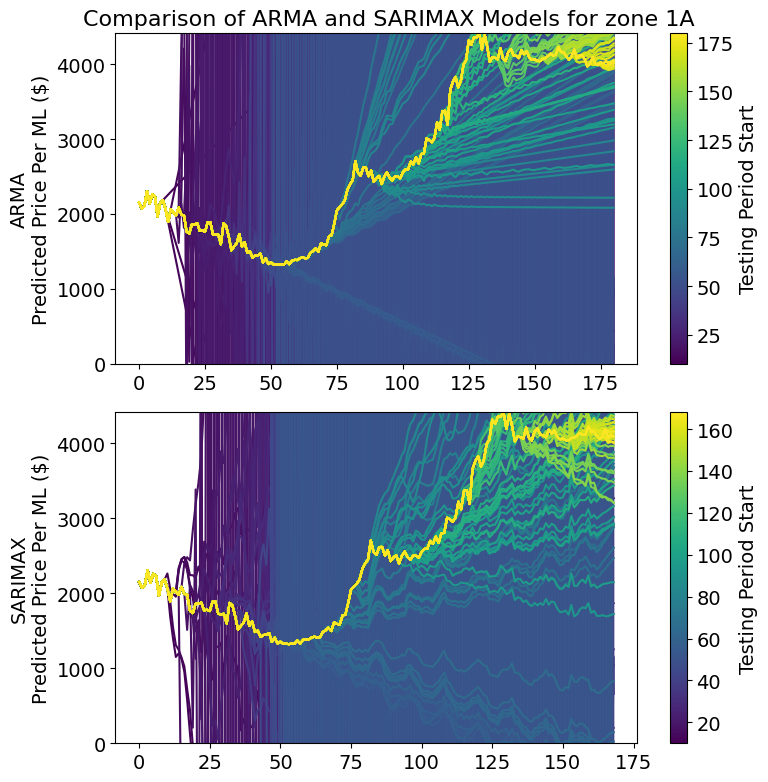

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'arma_price' and 'sarimax_price' are defined and the function 'read_and_plot' is properly implemented
arma_price = "ARMA Price"  # Ensure this variable is correctly assigned
sarimax_price = "SARIMAX Price"  # Ensure this variable is correctly assigned

def read_and_plot_every_fifth(dataset_name, ax, label=None, rank=False):
    df = pd.read_csv(dataset_name, index_col=0)
    # Select every 5th row from the DataFrame
    df = df.iloc[::1]  # Corrected to actually select every 5th row
    print(df.shape)

    if ax is not None:
        plot_dataset(df, ax)
        ax.set_ylabel(f"{label}\nPredicted Price Per ML ($)")


fig, axs = plt.subplots(2, 1, figsize=(8, 8))  # Create two subplots

# Read and plot only every 5th data point from the ARMA data on the first subplot
read_and_plot_every_fifth(f'{arma_price}.csv', ax=axs[0], label="ARMA", rank=True)

# Read and plot only every 5th data point from the SARIMAX data on the second subplot
read_and_plot_every_fifth(f'{sarimax_price}.csv', ax=axs[1], label="SARIMAX", rank=True)

fig.tight_layout()
fig.subplots_adjust(top=0.95)  # Adjust the top of the subplots to make space for the title

fig.suptitle("Comparison of ARMA and SARIMAX Models for zone 1A", fontsize=16)  # Adding a subtitle


plt.show()  # Display the plot

(30951, 4)
(26871, 4)


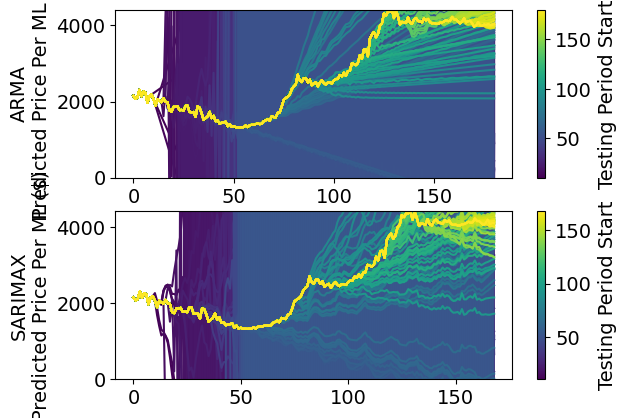

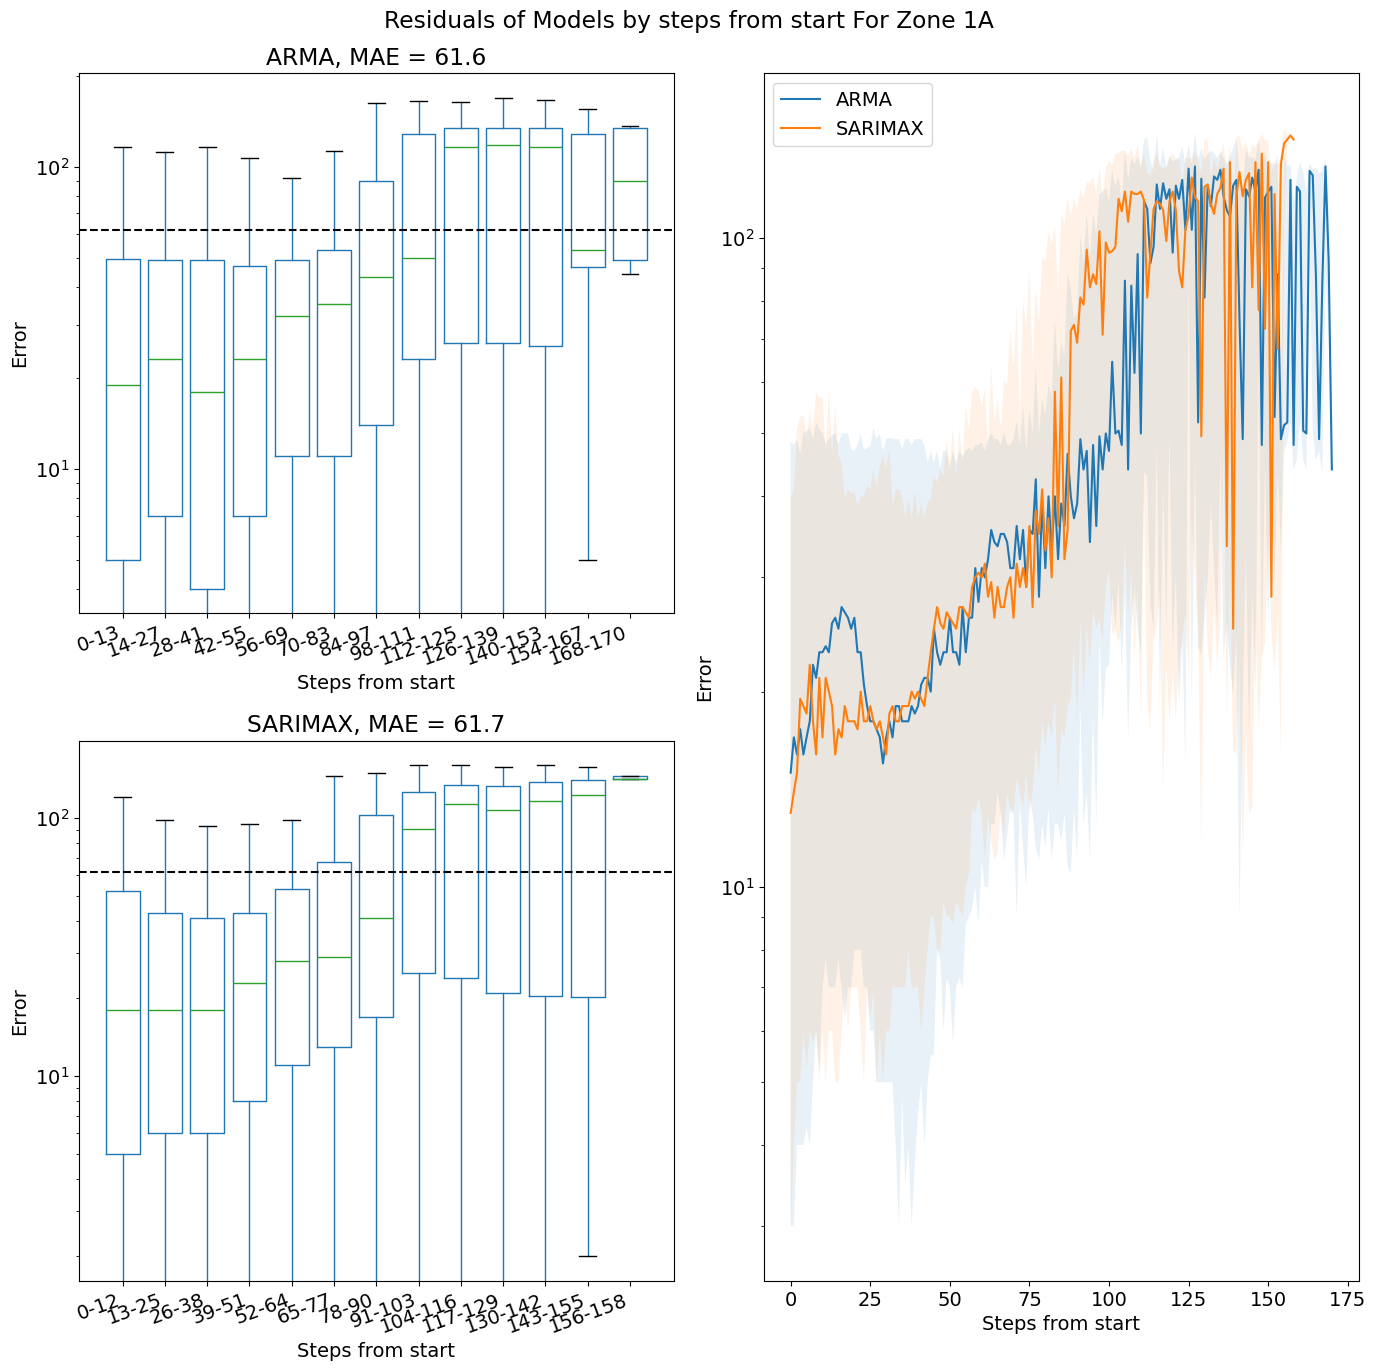

In [41]:
# Compare results in terms of ranking rather than value
fig, ax = plt.subplots(2)

#r_fig, resid_ax = plt.subplots(2, figsize=(10, 8))
r_fig, resid_ax = plt.subplot_mosaic([[0, 2], [1, 2]], figsize=(14, 14))

read_and_plot(f'{arma_price}.csv', ax[0], resid_ax[0], resid_ax[2], label="ARMA", rank=True)
ax[0].set_ylabel("ARMA\nPredicted Price Per ML ($)")

#USE RANK=TRUE to rank MAE rather than actual value
read_and_plot(f'{sarimax_price}.csv', ax[1], resid_ax[1], resid_ax[2], label="SARIMAX", rank=True)
ax[1].set_ylabel("SARIMAX\nPredicted Price Per ML ($)")

r_fig.tight_layout()
r_fig.suptitle("Residuals of Models by steps from start For Zone 1A")

resid_ax[2].legend()

## Positive Transformations

In [42]:
# Transform data before fitting model so that results are strictly positive

def transform_back(dataset_name, *args, func=scipy.special.inv_boxcox, **kwargs):
    df = pd.read_csv(f'{dataset_name}.csv', index_col=0)
    df[["lower", "upper", "value"]] = func(df[["lower", "upper", "value"]], *args, **kwargs)
    df.replace([-np.inf], 0, inplace=True)
    df.to_csv(f'{dataset_name}.csv')

def interval_constraint(data, a=10**4, b=0, inverse=False):
    if inverse:
        return a + np.exp(data)*(b-a)/(1+np.exp(data))
    
    return np.log((data-a)/(b-data))

def box_cox_model(data, kwargs):
    
    trans_data = scipy.stats.boxcox(data, lmbda=0)
    model = kwargs["model"]
    kargs = kwargs["kargs"]
    return model(data, **kwargs)

### Interval Constraint
Constrain the data to an interval by expanding the domain.

In [43]:
interval_arma = "ARMA interval"
trans_data = copy.deepcopy(new_data)
trans_data["Price Per ML ($)"] = interval_constraint(trans_data["Price Per ML ($)"])
make_dataset(trans_data, "Price Per ML ($)", interval_arma)


transform_back(interval_arma, inverse=True, func=interval_constraint)

KeyError: 'Price Per ML ($)'

In [ ]:
interval_sarimax = "SARIMAX interval"
trans_data = copy.deepcopy(new_data)
trans_data["Price Per ML ($)"] = interval_constraint(trans_data["Price Per ML ($)"])
make_dataset(trans_data, "Price Per ML ($)", interval_sarimax, model_func=sm.tsa.statespace.SARIMAX, exog_cols=new_data.columns[:10])


transform_back(interval_sarimax, inverse=True, func=interval_constraint)

### Boxcox Transformation

In [ ]:
boxcox_sarimax = "SARIMAX boxcox"
make_dataset(np.log(new_data), "Price Per ML ($)", boxcox_sarimax, model_func=sm.tsa.statespace.SARIMAX, exog_cols=[*new_data.columns[:10], "Volume Traded (ML)"])
transform_back(boxcox_sarimax, 0)

In [ ]:
boxcox = "ARMA boxcox"
make_dataset(np.log(zone_data), "Price Per ML ($)", boxcox)
transform_back(boxcox, 0)

## Comparison of results

In [ ]:
def compare_plots(fns, names, rank=True):
    fig, ax = plt.subplots(len(fns))
    r_fig, resid_ax = plt.subplot_mosaic([[n+1, 0] for n in range(len(fns))], figsize=(3*len(fns), 8))

    for i, (fn, name) in enumerate(zip(fns, names)):
        read_and_plot(fn, ax[i], resid_ax[i+1], resid_ax[0], label=name, rank=rank)
        ax[0].set_ylabel("Predicted Price Per ML ($)")
        ax[i].title.set_text(name)

    fig.tight_layout()
    r_fig.tight_layout()
    r_fig.suptitle("Residuals of Models by steps from start")

    resid_ax[0].legend()

In [ ]:
compare_plots([f'{arma_price}.csv', f'{sarimax_price}.csv', f'{interval_arma}.csv', f'{interval_sarimax}.csv',  f'{boxcox}.csv', f'{boxcox_sarimax}.csv'], ["ARMA", "SARIMAX", "ARMA Interval", "SARIMAX Interval",  "ARMA Boxcox", "SARIMAX Boxcox"])

In [ ]:
annual_grouped = zone_data_6.groupby(pd.Grouper(key="Create_date", freq='6M'))
# Take the median of the monthly price
annual_zone_data =  annual_grouped[["Price Per ML ($)", "Volume Traded (ML)"]].median().fillna(0)
# Take the sum of the monthly volume traded
annual_zone_data["Volume Traded (ML)"] =annual_grouped["Volume Traded (ML)"].sum().fillna(0)



In [ ]:
make_dataset(annual_zone_data, "Price Per ML ($)", "ARMA annual")

In [ ]:
std_price = grouped[["Price Per ML ($)", "Volume Traded (ML)"]].std()

In [ ]:
make_dataset(std_price, "Price Per ML ($)", "ARMA std price")

In [ ]:
fig, ax = plt.subplots(2)

#r_fig, resid_ax = plt.subplots(2, figsize=(10, 8))
r_fig, resid_ax = plt.subplot_mosaic([[0, 2], [1, 2]], figsize=(10, 8))

read_and_plot(f'ARMA std price.csv', ax[0], resid_ax[0], resid_ax[2], label="ARMA")

read_and_plot("ARMA annual.csv", ax[1], resid_ax[1], resid_ax[2], label="ARMA")

In [ ]:
ann_resampled = ann.assign(period = ann.index*6, start = ann.start*6)
ann_resampled_merge = pd.merge(ann_resampled, df, on=["start", "period"], how="outer", suffixes=(None, "y"))[ann_resampled.columns]
ann_resampled = ann_resampled_merge[np.in1d(ann_resampled_merge.start, ann_resampled.start)]

In [ ]:
std_arm = pd.read_csv("ARMA std price.csv")
std_arm

## Reading in predictions

In [ ]:
arma_price = "ARMA Price"
sarimax_price = "SARIMAX Price"

df = pd.read_csv(f"{sarimax_price}.csv", index_col=0)
df = MAEs(df)

In [ ]:
def initialise(df):
    df = df.assign(offset=df.index-df.start, period=df.index).reset_index()
    return df

In [ ]:
df = df.assign(offset=df.index-df.start, period=df.index).reset_index()

In [ ]:
import seaborn as sns

In [ ]:
#sns.displot(df.loc[(df.offset>0)&(df.offset<5)], x='error', hue='offset')

In [ ]:
offset_filter = (df.offset>0)&(df.offset<100)
hue = 'offset'
norm = plt.Normalize(df.loc[offset_filter, hue].min(), df.loc[offset_filter, hue].max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)


ax = sns.displot(df.loc[offset_filter], x='rank_error', hue=hue, kind='kde', palette='Spectral')
ax.legend.remove()

plt.colorbar(sm, ax=ax.axes[0][0])


In [ ]:
import matplotlib.animation

In [ ]:
frames[0]

In [ ]:
i = frames[10]
i = 5.4
(df.loc[df.offset==np.ceil(i)]*(i-np.floor(i))).reset_index() + ((np.ceil(i)-i)*df.loc[df.offset==np.floor(i), :][:-1]).reset_index()
#df.loc[df.offset==np.ceil(i)]*(i-np.floor(i)).add

In [ ]:
i = 10.0
lower  = (np.ceil(i)-i)*df.loc[df.offset==np.floor(i), :]
upper = df.loc[df.offset==np.ceil(i)]*(i-np.floor(i))
data = (upper.set_index('period') + lower[:-1].set_index('period')).reset_index()

data

In [ ]:
fig, ax = plt.subplots()
g = sns.kdeplot(df.loc[df.offset==0, :], x='rank_error', hue=hue, fill=True, ax=ax)
b = sns.histplot(df.loc[df.offset==0, :], x='rank_error', hue=hue, fill=True, ax=ax, stat='density')
#g.data = df.loc[df.offset==30, :]
ax.set_xlim(-200, 200)
def animate(i):
    global g
    global b
    g.clear()
    b.clear()
    hue='offset'
    if not np.issubdtype(type(i), np.integer):
        if np.floor(i)==np.ceil(i):
            i = int(i)
        else:
            lower  = (np.ceil(i)-i)*df.loc[df.offset==np.floor(i), :]
            upper = df.loc[df.offset==np.ceil(i)]*(i-np.floor(i))
            data = (upper.reset_index() + lower[:-1].reset_index())
    if np.issubdtype(type(i), np.integer):
        data = df.loc[df.offset==i, :]

    g = sns.kdeplot(data, x='rank_error', hue=hue, fill=True, ax=ax)
    b = sns.histplot(data, x='rank_error', hue=hue, fill=True, ax=ax, stat='density')
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 0.05)

#g.facet_axis(0, 0).clear()


#g.legend.remove()


frames = np.arange(20)
frames = np.linspace(1, df.offset.max(), num=300)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, repeat=True)

ani.save('errorchange.gif')


In [ ]:
df.value.min()

In [ ]:
df.loc[offset_filter]

In [ ]:
offset_filter = (df.offset>0)#&(df.offset<100)
hue = 'offset'
norm = plt.Normalize(df.loc[offset_filter, hue].min(), df.loc[offset_filter, hue].max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)


ax = sns.scatterplot(df.loc[offset_filter, :], x='value', y='rank_error', hue=hue, palette='Spectral')
#ax.legend().remove()
plt.xlim(0, df.value.quantile(0.91))
plt.colorbar(sm, ax=ax.axes)


In [ ]:
scipy.stats.spearmanr(df.dropna().loc[offset_filter, 'value'], df.dropna().loc[offset_filter, 'rank_error'])
#scipy.stats.pearsonr(df.dropna().loc[offset_filter, 'value'], df.dropna().loc[offset_filter, 'rank_error'])

In [ ]:
#s = plt.scatter(df.value, df.rank_error, c=df.offset)
sns.scatterplot(df, x='value', y='rank_error', hue='offset', palette='Spectral')
plt.xlim(0, df.value.quantile(0.9))
#plt.xscale('symlog')
plt.colorbar(s)

In [ ]:
filtered_df = df[df.offset>0].dropna()

def correct_for_column(filtered_df, xcol='offset', ycol='rank_error', by='start', corrected_col = 'corrected_error'):
    start_fits = pd.DataFrame(index=filtered_df.start.unique(), columns=[by, 'slope', 'intercept', 'rvalue', 'pvalue', 'R2'])
    for start in filtered_df[by].unique():
        filter_ = filtered_df[by]==start
        res = scipy.stats.linregress(filtered_df.loc[filter_, xcol], filtered_df.loc[filter_, ycol])
        start_fits.loc[start, :] = [start, res.slope, res.intercept, res.rvalue, res.pvalue, res.rvalue**2]

    start_fits = start_fits.fillna(0)

    # Correct for influence of start
    filtered_df[corrected_col] = filtered_df[ycol] - (start_fits.loc[filtered_df[by], 'slope'].values*filtered_df[xcol] + start_fits.loc[filtered_df[by], 'intercept'].values)
    plot_error_fitting(start_fits)

    return filtered_df

def plot_error_fitting(start_fits):

    fig, ax = plt.subplots(len(start_fits.columns[1:]), sharex=True)

    for i, col in enumerate(start_fits.columns[1:]):
       # sns.boxplot(start_fits, y=col, showfliers=False, ax=ax[i])
       # yl = ax[i].get_ylim()
        sns.scatterplot(start_fits, x=start_fits.columns[0], y=col, ax=ax[i], hue='R2')
        alpha = 0.1
        #plt.ylim(start_fits.loc[:, col].quantile(alpha), start_fits.loc[:, col].quantile(1-alpha))
       # ax[i].set_ylim(yl)
        ax[i].get_legend().remove()

In [ ]:
correct_for_column(filtered_df)

In [ ]:
filtered_df

In [ ]:
start_fits.slope.quantile(0.01)

In [ ]:
sns.regplot((filtered_df), x='offset', y='rank_error', logx=False, line_kws=dict(color="r"),scatter=False)
sns.scatterplot((filtered_df), x='offset', y='rank_error', hue='start', palette='Spectral')


In [ ]:
filtered_df['scaled_rank_error'] = filtered_df['rank_error']/(filtered_df.start.max()-filtered_df.start)

In [ ]:
df[df.offset==-1].set_index('start')

In [ ]:
def compare_start(df, col='Rank', colname="Start Rank", higher_col = "Higher", filter_=None):
    df[colname] = df.start
    df[colname] = df[colname].map(df[df.offset==-1].set_index('start')[col])

    if filter_ is None:
        filter_ = df.index
    df[higher_col] = df[col] > df[colname]

    return df

In [ ]:
_ = compare_start(df, "value")
_ = compare_start(df, "Observed", "Start Observed Rank", "Observed Higher")

In [ ]:
def plot_expected(df, upper, x='Observed Higher', y='Higher', hue='Start Observed Rank', ax=None):
    if ax is None:
        ax = plt.gca()
    filter_ = (df.offset >= 0) & (df.offset < upper) 
    sns.scatterplot(data = df[filter_].groupby('start').mean(), x=x, y=y, hue=hue, ax=ax)
    sns.regplot(data = df[filter_].groupby('start').mean(), x=x, y=y, scatter=False, ax=ax)

    ax.plot([0, 1], [0, 1])

In [ ]:
plot_expected(df, lookahead)

In [ ]:
filter_ = (df.offset>=0)&(~df.Higher)
sar_vol[filter_].groupby('start').sum()['value'] #- sv.loc[df.offset==-1, 'value'].values

In [ ]:
sar_vol

In [ ]:
filter_ = (df.offset>=0)&(~df["Observed Higher"])
sar_vol[filter_].groupby('start').sum()['Observed']

In [ ]:
sar_vol = MAEs(sar_vol.set_index('index'))

In [ ]:
new_data["Volume Cheaper"] = 0
for start in range(len(new_data.index)):
    start_data = new_data.iloc[start:]
    new_data.loc[new_data.index[start], "Volume Cheaper"] = start_data.where(start_data["Price Per ML ($)"]<start_data.iloc[0]["Price Per ML ($)"])["Volume Traded (ML)"].sum()
    

In [ ]:
sns.lineplot(new_data["Volume Cheaper"])

In [ ]:
sv[filter_].groupby('start').sum()

In [ ]:
sv[~df.Higher]

In [ ]:
uppers = df[df.offset>0].offset.unique()
MSE = np.zeros_like(uppers, dtype=np.float32)
for i, upper in enumerate(uppers):
    filter_ = (df.offset > 0) & (df.offset < upper) 

    data = df[filter_].groupby('start').mean()
    x='Observed Higher'
    y = 'Higher'

    #plt.scatter(upper, np.mean((data[y]-data[x])**2))
    MSE[i] = np.mean((data[y]-data[x])**2)

lookahead = uppers[np.nanargmin(MSE)]
sns.scatterplot(x=uppers, y=MSE)

In [ ]:
plot_expected(df, lookahead)

In [ ]:
sns.jointplot(data=zone_data, x='Price Per ML ($)', y='Volume Traded (ML)')

In [ ]:
sns.lineplot(zone_data, x=zone_data.index, y="Volume Traded (ML)")

In [ ]:
scipy.stats.spearmanr(zone_data["Volume Traded (ML)"], zone_data.reset_index().index)

In [ ]:
scipy.stats.pearsonr(new_data["Volume Traded (ML)"], new_data["Price Per ML ($)"])

In [ ]:

res = scipy.stats.linregress(new_data["Price Per ML ($)"], new_data["Volume Traded (ML)"])

# SARIMAX Volume

In [ ]:
# Create a new file called SARIMAX Volume
sarimax_volume = "SARIMAX Volume"
# Make it a SARIMAX model by passing the SARIMAX function and columns to be used as exogenous data
make_dataset(new_data, "Volume Traded (ML)", sarimax_volume, model_func=sm.tsa.statespace.SARIMAX, exog_cols=new_data.columns[:10])

In [ ]:
sarimax_volume = pd.read_csv("SARIMAX Volume.csv")

In [ ]:
sarimax_volume[sarimax_volume.offset<0].describe()

In [ ]:
new_data["Volume Traded Price Adjusted"] = new_data["Volume Traded (ML)"] - (res.slope*new_data["Price Per ML ($)"].values + res.intercept)

In [ ]:

print("Before Adjustment")
print(f'\t{scipy.stats.spearmanr(new_data["Volume Traded (ML)"], new_data.reset_index().index)}')
print("After Adjustment")
print(f'\t{scipy.stats.spearmanr(new_data["Volume Traded Price Adjusted"], new_data.reset_index().index)}')

In [ ]:
print("Before Adjustment")
print(f'\t{scipy.stats.spearmanr(new_data["Volume Traded (ML)"], new_data["Price Per ML ($)"])}')
print("After Adjustment")
print(f'\t{scipy.stats.spearmanr(new_data["Volume Traded Price Adjusted"], new_data["Price Per ML ($)"])}')

In [ ]:
fig, ax = plt.subplots(2)
sns.lineplot(new_data, x=new_data.index, y="Volume Traded (ML)", ax=ax[0])
sns.lineplot(new_data, x=new_data.index, y="Volume Traded Price Adjusted", ax=ax[1])

In [ ]:
sns.pairplot(new_data)

In [ ]:
sarimax_volume = "SARIMAX Volume"
make_dataset(new_data, "Volume Traded Price Adjusted", sarimax_volume, model_func=sm.tsa.statespace.SARIMAX, exog_cols=new_data.columns[:10])

In [ ]:
sar_vol = pd.read_csv(f"{sarimax_volume}.csv", index_col=0)
sar_vol = initialise(sar_vol)
sar_vol.value+=(res.slope*new_data.iloc[sar_vol.period, :]["Price Per ML ($)"].values + res.intercept)
sar_vol.to_csv("Readjusted SARIMAX Volume.csv")

In [ ]:
MAEs(sar_vol)

In [ ]:
sar_vol

In [ ]:

sar_vol.value

In [ ]:
sar_vol.value += new_data.iloc[sar_vol.start]

In [ ]:
sns.scatterplot(df[filter_], x='Start Rank', y='Start Observed Rank', hue='start')

plt.xlim(plt.gca().get_ylim())

In [ ]:
sv = pd.read_csv("Readjusted SARIMAX Volume.csv")

In [ ]:
fig, ax = plt.subplots(2)

#r_fig, resid_ax = plt.subplots(2, figsize=(10, 8))
r_fig, resid_ax = plt.subplot_mosaic([[0, 2], [1, 2]], figsize=(10, 8))

read_and_plot("Readjusted SARIMAX Volume.csv", ax[0], resid_ax[0], resid_ax[2], label="ARMA")
ax[0].set_ylabel("ARMA\nPredicted Price Per ML ($)")

read_and_plot(f'{sarimax_volume}.csv', ax[1], resid_ax[1], resid_ax[2], label="SARIMAX")
ax[1].set_ylabel("SARIMAX\nPredicted Volume")

r_fig.tight_layout()
r_fig.suptitle("Residuals of Models by steps from start")

resid_ax[2].legend()

In [ ]:


df["Start Observed Rank"] = df.start
df["Start Observed Rank"] = df["Start Observed Rank"].map(df[df.offset==0].set_index('start')['Observed Rank'])

df["Higher"] = df["Rank"] > df["Start Rank"]
df["Observed Higher"] = df["Observed Rank"] > df["Start Observed Rank"]

In [ ]:
df[df.period==df.start]

In [ ]:
df.groupby('start').mean()['Observed Higher']

In [ ]:
df[df.start==10].head(20)

In [ ]:
sns.boxplot(df['Observed Rank'])

In [ ]:
def plot_reg(filtered_df, x='offset', y='rank_error', ax=None):
    sns.regplot(abs(filtered_df), x=x, y=y, logx=False, line_kws=dict(color="k"),scatter=False, ax=ax)
    sns.scatterplot(filtered_df, x=x, y=y, hue='start', palette='Spectral', ax=ax)

In [ ]:
plot_reg(filtered_df, y='scaled_rank_error')

In [ ]:
plot_reg(filtered_df, y='rank_error')

In [ ]:
plot_reg(filtered_df, y='corrected_error')

In [ ]:
sns.regplot(abs(filtered_df), x='offset', y='start_corrected_error', logx=False, line_kws=dict(color="r"))
#plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(2)

x= np.arange(5)
for std in np.linspace(0.1, 10, num=5):

    ax[0].boxplot(gaussian(x,std, mu)/scipy.stats.norm.pdf(x,loc=mu, scale=std), positions=[std])

for mu in np.linspace(0, 10, num=5):

    ax[1].boxplot(gaussian(x,std, mu)/scipy.stats.norm.pdf(x,loc=mu, scale=std), positions=[mu])

In [ ]:
scipy.stats.gamma.shapes

In [ ]:
class customGaussian():
    def __init__(self, ):
        pass